# Large Sample Comparison Results

In this section we visualize the results of the different FDC estimation methods computed in previous notebooks. The methods are compared by plotting cumulative distribution functions (CDFs) to visualize the behaviour across the full sample, since in estimation in ungauged basins it is important to understand the range of outcomes more broadly.  The evaluation metrics include percent bias (PB), normalized absolute error (NAE), root mean square error (RMSE), Nash Sutcliffe Efficiency (NSE), and Kullback-Leibler divergence.  Each of these metrics emphasizes different aspects of the FDC estimation performance.  The goal is to understand how the different methods perform across the full range of flows, and to identify which methods are most robust across different conditions.


In [3]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import xarray as xr

import json
from multiprocessing import Pool

import geopandas as gpd
from shapely.geometry import Point
import xyzservices.providers as xyz
from scipy.stats import linregress

from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot, row, column, layout
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models.formatters import CustomJSTickFormatter

from bokeh.models import ColumnDataSource, LinearAxis, Range1d, HoverTool, Div
from bokeh.io import output_notebook
from bokeh.palettes import Sunset10, Vibrant7, Category20, Bokeh4, Bokeh6, Bokeh7, Bokeh8, Greys256, Blues256

from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter, FixedTicker
from bokeh.plotting import figure, show
from bokeh.transform import transform
from bokeh.palettes import RdBu

from bokeh.plotting import figure
from sklearn.linear_model import QuantileRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import NullFormatter, SymmetricalLogLocator

from shapely.geometry import Point

from utils.kde_estimator import KDEEstimator
from utils.fdc_estimator_context import FDCEstimationContext
from utils.fdc_data import StationData
from utils.evaluation_metrics import EvaluationMetrics

import utils.data_processing_functions as dpf

import xyzservices.providers as xyz
tiles = xyz['USGS']['USTopo']

output_notebook()

Loading BokehJS ...

In [4]:
attr_fpath = 'data/catchment_attributes_with_runoff_stats.csv'
attr_df = pd.read_csv(attr_fpath, dtype={'Official_ID': str})
station_ids = sorted(attr_df['official_id'].unique().tolist())

# streamflow folder from (updated) HYSETS
HYSETS_DIR = Path('/home/danbot/code/common_data/HYSETS')
hs_df = pd.read_csv('data/HYSETS_watershed_properties.txt', sep=';')
hs_df = hs_df[hs_df['Official_ID'].isin(station_ids)]

In [5]:
watershed_id_dict = {row['Watershed_ID']: row['Official_ID'] for _, row in hs_df.iterrows()}
# and the inverse
official_id_dict = {row['Official_ID']: row['Watershed_ID'] for _, row in hs_df.iterrows()}
# also for drainage areas
da_dict = {row['Official_ID']: row['Drainage_Area_km2'] for _, row in hs_df.iterrows()}

In [6]:
# retrieve LSTM ensemble predictions
LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results_20250514'# uses NSE mean as loss function
# LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results_20250627'# uses NSE 95% as loss function
lstm_result_files = os.listdir(LSTM_ensemble_result_folder)
lstm_result_stns = [e.split('_')[0] for e in lstm_result_files]

# filter for the common stations between BCUB region and LSTM-compatible (i.e. 1980-)
daymet_concurrent_stations = list(set(station_ids) & set(lstm_result_stns))
# assert '012414900' in daymet_concurrent_stations
print(f'There are {len(daymet_concurrent_stations)} monitored basins concurrent with LSTM ensemble results.')


There are 715 monitored basins concurrent with LSTM ensemble results.


In [8]:
#  load the formatted parametric/lstm results from the previous notebook
fdc_df = pd.read_csv('data/results/formatted_results_by_performance_measure.csv', dtype={'Official_ID': str})

# load the formatted knn results
knn_df = pd.read_csv('data/results/knn_all_results_formatted.csv', dtype={'Official_ID': str})
knn_df.head()


,Official_ID,Label,KLD,EMD,RMSE,MB,RB,MARE,NSE,KGE,VE,VB_PMF,VB_FDC,MEAN_FRAC_DIFF,NAE,k,tree_type,ensemble_weight,ensemble_method
0,08EE008,08EE008_1_NN_spatial_dist_ID1_timeEnsemble,1.647275,9.2369,101.903908,-5.582547,-42.754952,0.971015,0.311663,0.416766,0.572450,NaN,NaN,NaN,42.754952,1,spatial,ID1,timeEnsemble
1,08EE008,08EE008_2_NN_spatial_dist_ID1_timeEnsemble,0.759694,9.4638,37.908671,-4.844146,-37.099774,0.331892,0.065222,0.169427,0.623840,NaN,NaN,NaN,37.615969,2,spatial,ID1,timeEnsemble
2,08EE008,08EE008_3_NN_spatial_dist_ID1_timeEnsemble,0.797334,17.2109,117.718540,-12.605444,-96.541087,1.174018,0.382154,0.422637,0.034589,NaN,NaN,NaN,96.541087,3,spatial,ID1,timeEnsemble
3,08EE008,08EE008_4_NN_spatial_dist_ID1_timeEnsemble,1.090815,12.8233,109.779929,-8.629510,-66.090676,1.079074,0.346536,0.418157,0.339093,NaN,NaN,NaN,66.090676,4,spatial,ID1,timeEnsemble
4,08EE008,08EE008_5_NN_spatial_dist_ID1_timeEnsemble,1.452076,15.2307,137.261906,-10.995796,-84.213306,1.360373,0.471264,0.485223,0.157867,NaN,NaN,NaN,84.213306,5,spatial,ID1,timeEnsemble


Load the global mean PMF and resample to the higher resolution evaluation grid (12 bits)

In [9]:
# import the mean global PMF
mean_pmf_df_bits = pd.read_csv('data/results/mean_distribution_8bits.csv')
mean_pmf_df_bits.drop(columns=['Unnamed: 0'], inplace=True)
# upsample to the 12 bits over the same range
a, b = mean_pmf_df_bits['left_log_edges'].min(), mean_pmf_df_bits['right_log_edges'].max()
log_edges_10bit = np.linspace(a, b, 2**10 + 1)
log_x_10bit = 0.5 * (log_edges_10bit[:-1] + log_edges_10bit[1:])
# interpolate the mean_pmf_df to the 12-bit edges
pmf_12bit_resampled = np.interp(
    x=log_x_10bit,
    xp=mean_pmf_df_bits['log_x'],
    fp=mean_pmf_df_bits['pmf']
)
mean_pmf_df = pd.DataFrame({
    'left_log_edges': log_edges_10bit[:-1],
    'right_log_edges': log_edges_10bit[1:],
    'log_x': log_x_10bit,
    'pmf': pmf_12bit_resampled,
})
mean_pmf_df['pmf'] /= mean_pmf_df['pmf'].sum() # normalize

In [10]:
def load_and_filter_hysets_data(station_ids, hs_df):
    hs_df = hs_df[hs_df['Official_ID'].isin(station_ids)]

    # load the updated HYSETS data
    updated_filename = 'HYSETS_2023_update_QC_stations.nc'
    ds = xr.open_dataset(HYSETS_DIR / updated_filename)

    # Get valid IDs as a NumPy array
    selected_ids = hs_df['Watershed_ID'].values

    # Get boolean index where watershedID in selected_set
    # safely access watershedID as a variable first
    ws_ids = ds['watershedID'].data  # or .values if you prefer
    mask = np.isin(ws_ids, selected_ids)

    # Apply mask to data
    ds = ds.sel(watershed=mask)
    # Step 1: Promote 'watershedID' to a coordinate on the 'watershed' dimension
    ds = ds.assign_coords(watershedID=("watershed", ds["watershedID"].data))

    # Step 2: Set 'watershedID' as the index for the 'watershed' dimension
    return ds.set_index(watershed="watershedID")

ds = load_and_filter_hysets_data(station_ids, hs_df)

In [11]:
def compute_empirical_cdf(data):
    """Compute the empirical CDF of the data.
    Address missing, NaN, and non-finite values by removing them.
    """
    # data = data[~np.isnan(data) & np.isfinite(data)]  
    # remove to see the CDFs without filtering
    assert np.all(np.isfinite(data))
    sorted_data = np.sort(data)  
    # print('sorted_data: ', sorted_data[:5])
    n = len(sorted_data)
    cdf = np.arange(1, n + 1) / (n + 1)
    # print(f'    min cdf = {np.min(cdf):.2f}')
    return sorted_data, cdf


def retrieve_timeseries_discharge(stn, ds):
    watershed_id = official_id_dict[stn]
    # drainage_area = self.ctx.da_dict[stn]
    # data = self.ctx.data
    df = ds['discharge'].sel(watershed=str(watershed_id)).to_dataframe(name='discharge').reset_index()
    df = df.set_index('time')[['discharge']]
    df['zero_flow_flag'] = df['discharge'] == 0
    df.dropna(inplace=True)
    # clip minimum flow to 1e-4
    df['discharge'] = np.clip(df['discharge'], 1e-4, None)
    df.rename(columns={'discharge': stn}, inplace=True)
    df[f'{stn}_uar'] = 1000 * df[stn] / da_dict[stn]
    return df


def compare_results_and_input(stn, sim_df, ds):
    """Compare the input streamflow timeseries with the observed streamflow timeseries.
    Check that the dates in the output match the common dates between Daymet and the input data.
    """
    input_df = retrieve_timeseries_discharge(stn, ds)
    # clip the 'discharge' column to 1e-4, convert to unit area runoff (L/s/km2), and take the log
    input_df = input_df[input_df.index >= '1980-01-01']

    df = pd.concat([input_df, sim_df], axis=1, join='inner')
    df.dropna(inplace=True)

    df['streamflow_obs'] = np.exp(df['streamflow_obs'])
    sim_cols = [c for c in sim_df.columns if c.startswith('streamflow_sim')]
    df[sim_cols] = np.exp(df[sim_cols])
    # assert that the 'log_obs' and the 'streamflow_obs' columns are approximately equal

    # set tolerance in the order of 1 L/s/km2
    if not np.allclose(df[f'{stn}_uar'], df['streamflow_obs'], atol=1): 
        max_diff = np.abs(df[f'{stn}_uar'] - df['streamflow_obs']).max()
        print(f'Warning: {stn} has a max difference of {max_diff:.2f} between the input and output streamflow timeseries.')
        # find the dates around the max difference index
        # diff_index = np.abs(df['uar'] - df['streamflow_obs']).idxmax()
        # print(diff_index)
        # view 5 before and 5 after the max diff index
        # print(df.loc[diff_index - pd.Timedelta(days=5):diff_index + pd.Timedelta(days=5), ['uar', 'streamflow_obs']].head(10))
        
    return df


def process_lstm_station(args):
    stn, folder, ds = args
    try:
        fpath = os.path.join(folder, f'{stn}_ensemble.csv')
        df = pd.read_csv(fpath)
        df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        result = compare_results_and_input(stn, df, ds)
        return stn, result
    except Exception as e:
        print(f"Failed to process {stn}: {e}")
        return stn, None

In [12]:
# retrieve LSTM ensemble predictions
# filter for the common stations
common_stations = list(set(station_ids) & set(lstm_result_stns))
print(f'There are {len(common_stations)} monitored basins with LSTM ensemble results.')
# attr_df = attr_df[attr_df['official_id'].isin(common_stations)]

# args_list = [(stn, lstm_result_folder, ds) for stn in common_stations]

# with Pool() as pool:
#     lstm_results = dict(pool.map(process_lstm_station, args_list))

There are 715 monitored basins with LSTM ensemble results.


In [13]:
# load the predicted parameter results (Notebook 3)
target_cols = [
    'uar_mean_predicted', 'uar_std_predicted', 'uar_median_predicted', 'uar_mad_predicted',
    'log_uar_mean_predicted', 'log_uar_std_predicted', 'log_uar_median_predicted', 'log_uar_mad_predicted',
]

parameter_prediction_results_folder = 'data/results/parameter_prediction_results'
predicted_params_fpath   = os.path.join(parameter_prediction_results_folder, 'OOS_parameter_predictions.csv')
stats = pd.read_csv(predicted_params_fpath, index_col=['official_id'], dtype={'official_id': str})
stats.head()
stats.columns = ['_'.join(c.split('_')) for c in stats.columns]
print(f' Loaded {len(stats)} stations with predicted parameters from {predicted_params_fpath}')    

 Loaded 1098 stations with predicted parameters from data/results/parameter_prediction_results/OOS_parameter_predictions.csv


In [14]:
plots = []
m1s = ['log_uar_mean_actual', 'log_uar_std_actual']
m2s = ['log_uar_median_actual', 'log_uar_mad_actual']
for m1, s1 in [m1s, m2s]:
    p = figure(title=f'Observed {m1} vs. {s1} over (N={len(stats)})', width=600, height=350)
    slope, intercept, r_value, p_value, std_err = linregress(stats[m1], stats[s1])
    p.scatter(stats[m1], stats[s1], size=10, color='green', alpha=0.5, legend_label='Observed')
    x = np.linspace(stats[m1].min(), stats[m1].max(), 100)
    p.line(x, slope * x + intercept, color='red', legend_label=f'Y={slope:.2f}x + {intercept:.2f} (R²={r_value**2:.2f})', line_width=2)
    p.xaxis.axis_label = f'Log {m1.split('_')[2]} unit area runoff (L/s/km²)'
    p.yaxis.axis_label = f'Log {s1.split('_')[2]} of unit area runoff (L/s/km²)'
    # p.legend.location = 'top_left'
    p = dpf.format_fig_fonts(p,font_size=14)
    plots.append(p)
lt = column(plots)
# show(lt)

### Load Results

We started by asking about the "simplest" approximation of an FDC, the parametric approximation from predicted values.  

1. First, let's review the predicted and "observed" mean, standard deviation, log-mean, and log-standard deviation predicted from catchment attributes.  This will give us a first clue of what to expect as far as which approach yields the better approximation of the FDC.  Since we're predicting these values using an objective function that minimizes the difference between predicted and observed values, we should first look at the distribution of the target values, since some metrics are sensitive to skewness and outliers.  
 

In [15]:
hist_plots, plots = [], []
for target in target_cols:
    
    obs_label = '_'.join(target.split('_')[:-1]) + '_actual'
    pred, obs = stats[target].values, stats[obs_label].values
    # get the regression results from scipy.stats.linregress()
    slope, intercept, r_value, p_value, std_err = linregress(obs, pred)
    f = figure()
    x = np.linspace(obs.min(), obs.max(), 100)
    y = slope * x + intercept    
    
    f.scatter(obs, pred, size=2, color='black', alpha=0.5, legend_label=f'{target}')
    f.line(x, y, line_color='firebrick', line_width=2, legend_label=f'{target} (R²={r_value**2:.2f})')
    f.legend.location = 'top_left'
    f.yaxis.axis_label = f'Predicted {target} (L/s/km²)'
    f.xaxis.axis_label = f'Observed {target} (L/s/km²)'
    
    # Create histogram data
    hist, edges = np.histogram(obs, bins=20)
    hist = hist / hist.sum() * 100  # Normalize to percentage

    # Prepare data for quad glyph: left and right edges of bins\
    hist_source = ColumnDataSource(data=dict(
        left=edges[:-1],
        right=edges[1:],
        top=hist,
        bottom=np.zeros_like(hist)
    ))

    # Create figure
    hist_plot = figure(width=450, height=100, x_axis_label=target, y_axis_label='Percentage')

    # Plot using quad
    hist_plot.quad(
        top='top', bottom='bottom', left='left', right='right',
        source=hist_source,
        fill_color='dodgerblue', fill_alpha=0.5, line_color='black'
    )

    # Optional styling
    hist_plot.xaxis.axis_label = target
    hist_plot.yaxis.axis_label = 'P(x)'
    f.legend.background_fill_alpha = 0.3
    f = dpf.format_fig_fonts(f, font_size=12)
    hist_plots.append(hist_plot)
    plots.append(f)


In [16]:
lt = gridplot(plots, ncols=4, width=350, height=300)
# show(lt)

From the plots above, the coefficient of determination around 0.8 for the mean and standard deviation show that these are reasonably well predicted from catchment attributes.  The log-mean is also fairly predictable, but the log-standard deviation is not.  This might lead us to expect that the FDC approximation based on the predicted log-mean and log-stdev might be worse than the approximation based on the predicted mean and stdev.  However, the method of moments must still be applied to the mean and stdev to get the log-normal parameters.  

The question is how the structural error introduced by the method of moments interacts with the parametric model, and how the log-transform affects the distribution of the target variables and the objective function of the predictive model by extension.  While the log-transform doesn't change the rank of the values, it still changes the emphasis on the objective function of the predictive model, since the model's performance can vary significantly based on the distribution of the input data.  By de-emphasizing the tails by the log-transform, we are effectively changing the model's focus to the central tendency of the data.  (should we consider quantile regression or another form of robust regression)?

## kNN - based FDC approximation

### Nuance of "concurrent" kNN: k or not k?

When using kNN derived from sparse monitoring networks with inconsistent coverage, the "k" isn't exactly "k".  At the timestep level, addressing gaps in data yields different interpretations of k, where the simplest interpretation is that it represents the number of independent monitoring locations used to generate an ensemble simulation of an unmonitored location.  Werstuck and Coulibaly (2018) describe infilling data gaps with kNN, effectively a nested kNN, which appears most consistent with the "dynamic k" described below, but it is not the same, rather the infilled data are a temporal mean which suppresses the variability of the ensemble.  Below we describe several variants that address data gaps in kNN selection, and how they relate to the concept of k.:

* **Maximum k**:  The maximum number of stations that can be used to generate an ensemble simulation.  In the event of missing observations at one or more k, the effective number of stations is less k.  Overall, $k_\text{actual} \leq k$.  Given periods of concurrent gaps, the ensemble simulation could effectively be much lower than k, though it must be at least 1.
* **Strict k**: The number of stations used to generate an ensemble simulation is strictly k.  This method is related to the set-cover problem, where the goal is to select a subset of stations that maximizes the intersection of their data availability over a specified time period.  The problem is NP-hard and requires a greedy or approximate subset selection strategy when exhaustively testing all combinations becomes computationally infeasible.  I set a lenient minimum concurrent period (5 complete periods of 12 consecutive complete months (minimum 10 days per month)) to avoid expensive computation.  This is more truly "k-nearest", but it achieves this by searching further away in the network and ignoring potentially more relevant information if it is not concurrent with all records -- the higher the k, the greater chance of misalignment of records.
* **Effective k**:  The number of stations used to generate the ensemble simulation increases until average k observations per timestep.  In the event of missing observations at one or more k, more (less similar, more distant) stations must be incorporated to yield an average of k ensemble members per timestep.  Overall, $k_\text{actual} \geq k$.  This requires generating weights per timestep such that they sum to 1 where the set comprising k are not constant.
* **Dynamic k**: The number of stations overall to generate an ensemble simulation varies, but we guarantee that the number of stations used to generate the simulation is **k at each timestep**.  Here k is really fixed but the stations may vary across timesteps.


The goal is to better understand the trade-off between the selection criteria and the performance of the kNN method under as broad a range of conditions as possible.  On the one hand, we can be strict in the temporal sense that it is only valid to compare observations that occurred at the same time, but another interpratation is that a significant proportion of the interannual variability can be captured given sufficient data, and more of the interannual variability can be covered by not requiring concurrency.  Strictness in the spatial (neighbour) sense means we take exactly the same k neighbours, but this leads to loss of data because more distant neighbours must be sought to satisfy the "k" contributors constraint, whereas we can interpret it as "take the best information where it's available, and resort to potentially less relevant contributors if necessary to fill gaps.


In [17]:
def get_result_and_ids(label, metric):
    # print(fdc_df.columns)
    # print(label, metric)
    data = fdc_df[fdc_df['Label'] == label].copy()
    data = data.dropna(subset=[metric])
    values = data[metric].values
    return values, data['Official_ID']


def get_knn_group_results(tree_type='attribute', ensemble_type='freqEnsemble', weighting='ID2', k=7, which_set='knn'):
    data = knn_df.copy()
    data = data[data['tree_type'] == tree_type]
    data = data[data['ensemble_method'] == ensemble_type]
    data = data[data['ensemble_weight'] == weighting]
    data = data[data['k'] == k]
    return data


def load_model_data(label, model_key, dm):
    """Load and return data and IDs for a given model and metric."""
    if '-NN' in label:
        k = int(label.split('-')[0])
        df = get_knn_group_results(k=k)
        values = df[dm].values
        return values, df['Official_ID'].values 

    elif label.startswith('LSTM') and '4NN' not in label:
        key = 'time' if 'Time' in label else 'frequency'
        df = fdc_df[fdc_df['Label'] == key]
        return df[dm].values, df['Official_ID'].values

    elif '4NN' in label:
        if label == 'LSTM-LN-4NN':
            fname = 'knn-lstm-lognorm_4NN.csv'
        elif label == 'LSTM-4NN':
            fname = 'knn-lstm_4NN.csv'
        elif label == 'LN-4NN':
            fname = 'knn-lognorm_4NN.csv'
        else:
            raise ValueError(f'Unknown 4NN label: {label}')
        df = pd.read_csv(os.path.join('data/results/ensemble_results', fname))
        key_map = {'RB': 'pct_vol_bias', 'MB': 'mean_error', 'RMSE': 'rmse', 'KLD': 'kld', 'NSE': 'nse', 
                   'VE': 've'}
        if dm == 'NAE':
            data = 100 * (1 - df['ve'].values)
        else:
            data = df[key_map[dm]].values
        if dm == 'RMSE':
            data = 100 * (np.exp(data) - 1)
        elif dm == 'RB':
            data = 100 * data
        elif dm == 'NSE':
            data = 1 - data
        elif dm in ['VE']:
            data = 100 * (1 - data)        
        assert not np.isnan(data).any(), f'NaNs in {label} {dm}'
        return data, df['stn_id'].values
    else:
        return get_result_and_ids(model_key, dm)

In [18]:
model_specs = [
    ('MLE', 'dashed', 'grey', 'MLE* LogNorm'),
    ('PredictedMOM', 'dashed', 'black', 'MoM LogNorm'),
    ('PredictedLog', 'solid', 'black', 'LogNorm'),
    ('2-NN', 'solid', 'orange', '2-NN'),
    ('8-NN', 'dashed', 'orange', '8-NN'),
    ('LSTM Time', 'dotted', 'green', 'LSTM Time'),
    ('LSTM Dist.', 'solid', 'green', 'LSTM Dist.'),
    ('LN-4NN', 'dotted', 'magenta', 'LN-4NN'),
    ('LSTM-4NN', 'solid', 'magenta', 'LSTM-4NN'),
    ('LSTM-LN-4NN.', 'dashed', 'magenta', 'LSTM-LN-4NN'),
]
all_metrics = ['RB', 'NAE', 'RMSE', 'NSE', 'KLD', ]#, 'VB_FDC', 'MEAN_FRAC_DIFF']
axis_labels = [
    r'$$\text{PB} \text{ [\%]}$$',
    r'$$\text{NAE} \text{ [\%]}$$',
    r'$$\text{RMSE } [\%]$$',
    r'$$1 - \text{NSE} \text{ [-]}$$',
    r'$$\text{KLD} \text{ [bits/sample]}$$',
]
plotting_metrics = [m for m in all_metrics if m != 'RB']
plotting_axis_labels = [e for e in axis_labels if 'PB' not in e]

In [38]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, LogLocator, FixedLocator

def plot_parametric_bounds(f, dm, lb_label='MLE', rb_label='RandomDraw', label='LogNorm bounds', color='black', divide_re=1.):
    ub = fdc_df[fdc_df['Label'] == lb_label][dm].values
    lb = fdc_df[fdc_df['Label'] == rb_label][dm].values
    print(dm, 'parametric bounds', len(ub), len(lb))
    x2, y = compute_empirical_cdf(ub)
    x1, _ = compute_empirical_cdf(lb)
    f.harea(x1=x1, x2=x2, y=y, fill_color=color, fill_alpha=0.3, legend_label=label)
    # plot the mean pmf line
    for label in ['Mean_PMF', 'Uniform']:
        new_pmf = fdc_df[fdc_df['Label'] == label][dm].values
        x_mean, y_mean = compute_empirical_cdf(new_pmf)
        f.line(x_mean, y_mean, line_color='red', line_width=2, legend_label='Mean PMF')
    return f, max(np.max(x1), np.max(x2))

def plot_parametric_bounds_matplotlib(ax, dm, fdc_df, divide_re=1.0, #mean_pmf,
                                      lb_label='MLE', rb_label='RandomDraw',
                                      label='LogNorm bounds', color='black', alpha=0.25):
    ub = fdc_df[fdc_df['Label'] == lb_label][dm].values
    lb = fdc_df[fdc_df['Label'] == rb_label][dm].values

    x2, y = compute_empirical_cdf(ub)
    x1, _ = compute_empirical_cdf(lb)
    ax.fill_betweenx(y, x1, x2, color=color, alpha=alpha, label=label)
    for l, c in zip(['Mean_PMF', 'Uniform'], ['red', 'brown']):
        if l == 'Uniform':
            continue
        new_pmf = fdc_df[fdc_df['Label'] == l][dm].values
        mn, _ = compute_empirical_cdf(new_pmf)
        ax.plot(mn, y, color=c, linewidth=2, label=l)

    return max(np.max(x1), np.max(x2), np.max(mn))

def add_vertical_spans(ax, ticks):
    ticks = list(ticks)
    for i in range(0, len(ticks) - 1, 2):
        ax.axvspan(ticks[i], ticks[i+1], 
                   facecolor='none', edgecolor='grey', alpha=0.2)
        
def create_knn_plots_matplotlib_grid(results_dfs, completed_stns, all_metrics, metric_label_dict, ncols=3, savepath=None):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter
    from bokeh.palettes import Sunset10

    knn_df = results_dfs.copy()
    combos = [
        ('ID2', 'timeEnsemble', 'spatial'),
        ('ID2', 'freqEnsemble', 'spatial'),
        ('ID2', 'freqEnsemble', 'attribute'),
    ]
    
    clrs = Sunset10
    ncols = len(combos)

    total = len(all_metrics) * len(combos)
    nrows = (total + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axs = axs.flatten()
    plot_idx = 0

    n = 1
    for metric in all_metrics:
        for wm, ensemble, tree in combos:
            df = knn_df.query(
                "ensemble_weight == @wm and ensemble_method == @ensemble and tree_type == @tree"
            )
            if df.empty:
                print(f"No data for {tree} {ensemble} {metric}")
                continue

            ax = axs[plot_idx]       
            legend_loc = 'upper left'
            plot_idx += 1
            linthresh = 1.0
            # bound_metric = metric if metric != 'RB' else 'MAE'
            max_val = plot_parametric_bounds_matplotlib(ax, metric, fdc_df)
            # tick_loc = 1
            if metric == 'RB':
                linthresh = 100
                xmin, xmax = -5, 500
                b_xmin, b_xmax = 100, 1000
                ticks = [0, 25, 50, 75, 100, 200, 500]
                add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 25))
                str_format = '%.0f'
            elif metric == 'NSE':
                linthresh = 0.5
                xmin, xmax = -0.05, 5.0
                b_xmin, b_xmax = 0.5, 10
                ticks = [0, 0.25, 0.5, 1.0, 2.0, 5.0]
                add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 0.25))
                str_format = '%.2f'
            elif metric == 'KLD':
                linthresh = 1.0
                xmin, xmax = 0.0, 2
                b_xmin, b_xmax = linthresh, 5
                ticks = [0, 0.25, 0.5, 0.75, 1.0, 2.0]
                add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 0.25))
                str_format = '%.2f'
            elif metric == 'NAE':
                linthresh = 100
                xmin, xmax = -5, 505
                b_xmin, b_xmax = linthresh, 500
                ticks = [0, 25, 50, 75, 100, 200, 500]
                add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 20))
                str_format = '%.0f'
            else:                
                linthresh = 100.0
                xmin, xmax = -1, 500
                b_xmin, b_xmax = 100, 500
                ticks = [0, 25, 50, 75, 100, 200, 500]
                add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 25))
                str_format = '%.0f'

            minor_positions = ticks
            ax.set_xscale('symlog', linthresh=linthresh)
            ax.set_xlim(xmin, xmax)
            ax.axvspan(b_xmin, b_xmax, alpha=0.3, color='red', label='log x-scale')
            ax.axvline(0, ymin=0, ymax=1, color='grey', linestyle='dashed', alpha=0.5)
            ax.set_xticks(ticks)
            ax.xaxis.set_major_formatter(FormatStrFormatter(str_format))
            # minor ticks/gridlines: use LogLocator for positive and negative ranges
            ax.xaxis.set_minor_locator(FixedLocator(minor_positions))
            ax.xaxis.set_minor_formatter(NullFormatter())   # suppress labels
            ax.tick_params(axis='x', which='minor', length=3)

            e_label = 'timeEnsemble' if ensemble.startswith('time') else 'distEnsemble'
            ax.set_title(f'{tree} dist., {e_label} avg.', fontsize=10)

            # plot the Log normal model result distribution
            pv = fdc_df[fdc_df['Label'] == 'PredictedLog'][metric].values
            x_ln, y_ln = compute_empirical_cdf(pv)
            ax.plot(x_ln, y_ln, color='black', linestyle='solid', linewidth=2, label='LogNorm')

            for i in range(1, 11):
                vals = df[df['k'] == i][metric].values
                assert len(vals) == len(completed_stns), f'   len(vals)={len(vals)} vs. {len(completed_stns)} for {i}NN {tree} {ensemble} {metric}'
                x, y = compute_empirical_cdf(vals)
                ax.plot(x, y, label=f'{i}NN', color=clrs[i - 1], lw=2)
            
            
            ax.set_ylabel(r'$P(X \geq x)$', fontsize=12)
            ax.set_xlabel(metric_label_dict[metric][1:-1], fontsize=12)
            if n == 3:
                ax.legend(loc='lower right', framealpha=0.6, fontsize=7)
            else:
                ax.legend(loc='lower right', framealpha=0.6).set_visible(False)

    # Remove unused subplots
    for j in range(plot_idx, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=150)
    return fig



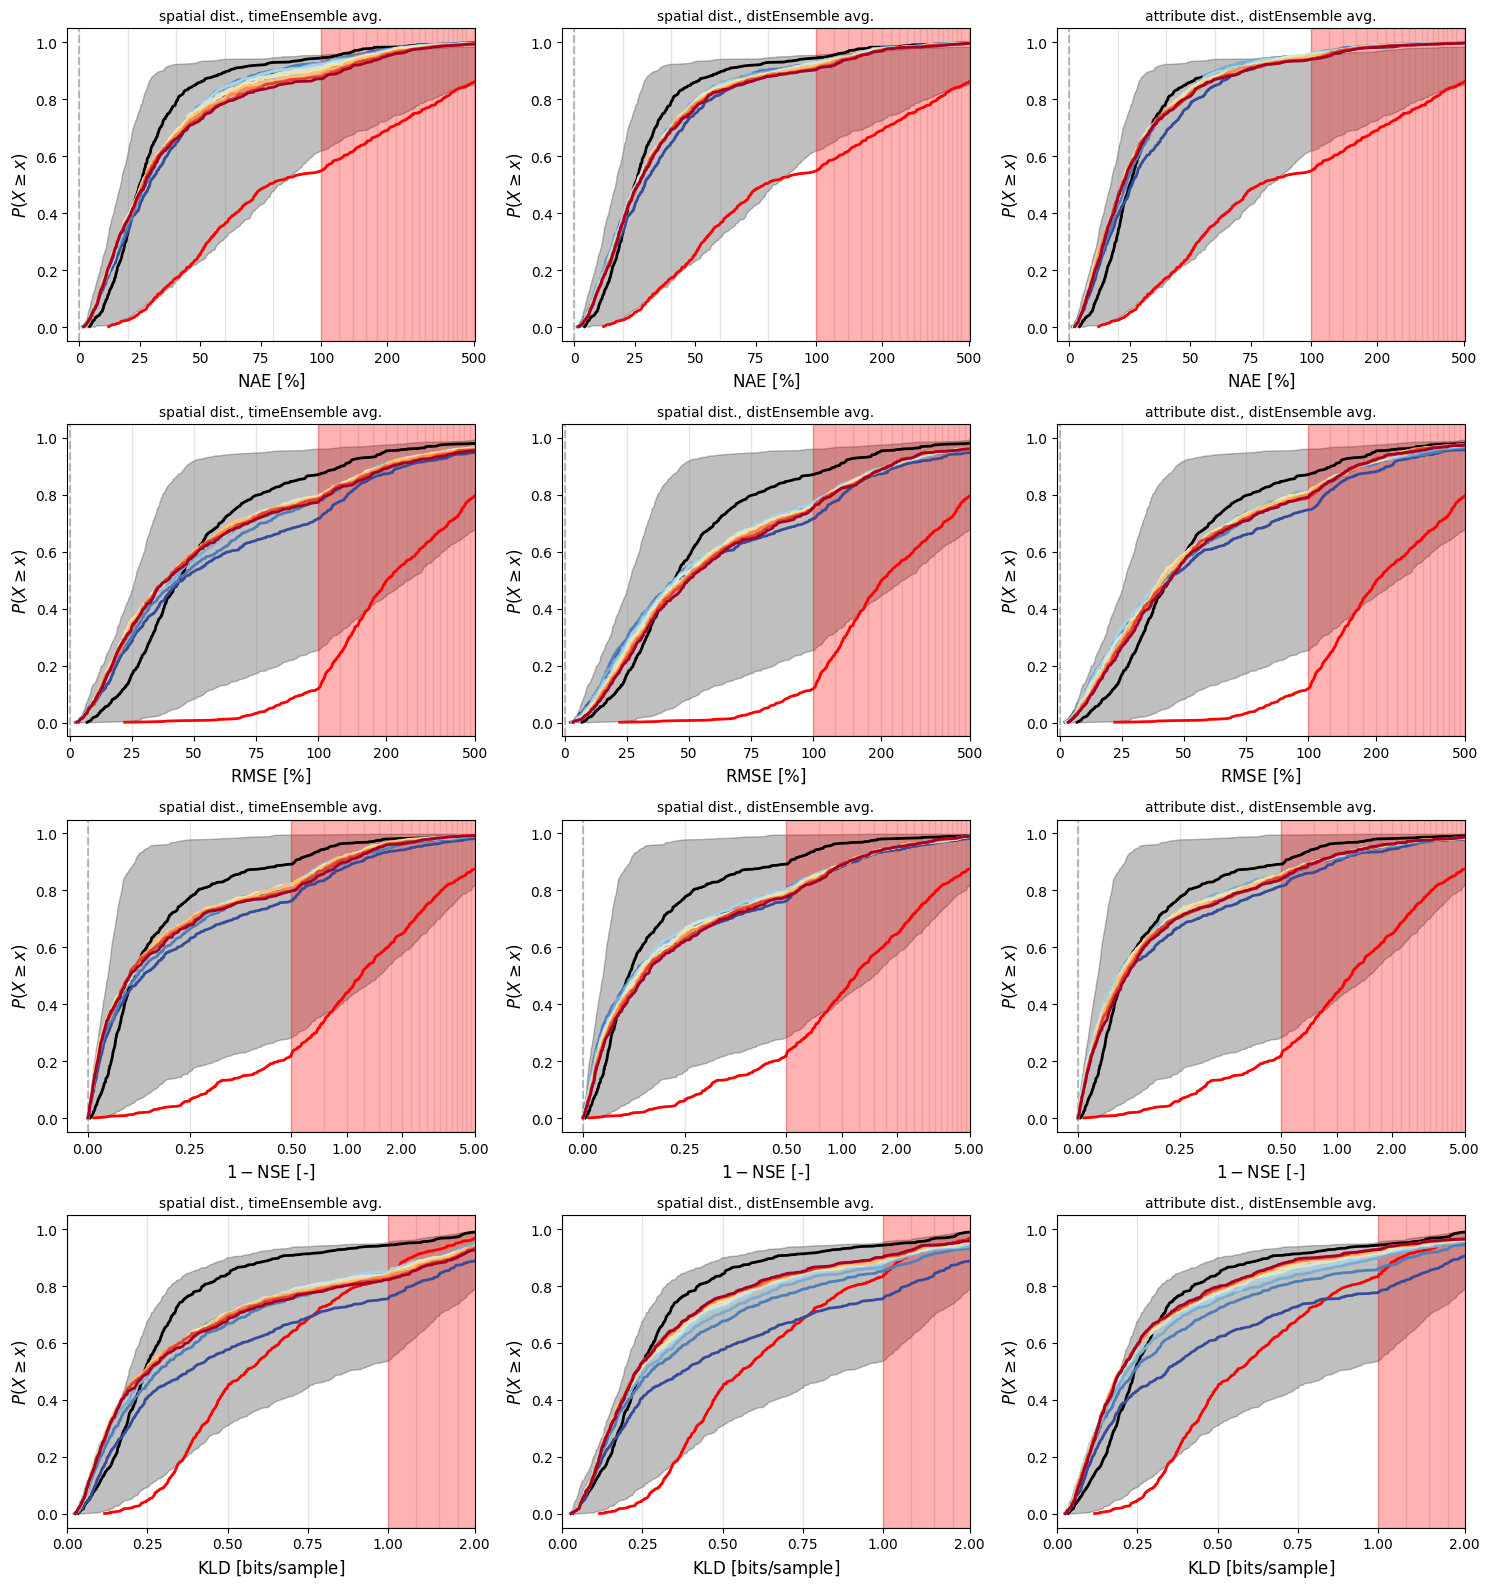

In [39]:
plotting_axis_labels = [
    r'$$\text{NAE} \text{ [\%]}$$',
    r'$$\text{RMSE } [\%]$$',
    r'$$1 - \text{NSE} \text{ [-]}$$',
    r'$$\text{KLD} \text{ [bits/sample]}$$',
]
metric_label_dict = dict(zip(plotting_metrics, plotting_axis_labels))
plots = create_knn_plots_matplotlib_grid(knn_df, common_stations, plotting_metrics, metric_label_dict, ncols=3, savepath='images/knn_plot_subset.png')

## Plot CDFs of error metrics for all models

In [41]:
from bokeh.models.formatters import CustomJSTickFormatter
# create labels for symmetric log axes
symlog_formatter = CustomJSTickFormatter(code="""
    const lin_thresh = 1.0;
    const abs_tick = Math.abs(tick);
    let original;

    if (abs_tick <= lin_thresh) {
        original = tick;
    } else {
        original = Math.sign(tick) * Math.exp(abs_tick - Math.log(lin_thresh));
    }

    const val = original * 100;
    const abs_val = Math.abs(val);
    const rounded = Math.round(abs_val);

    if (rounded === 0) {
        return "0%";
    }

    return (val < 0 ? "-" : "") + rounded.toString() + "%";
""")

plots = []

main_result_vals = {}
for dm, x_label in zip(all_metrics, axis_labels):
    for model_key, line_style, color, label in model_specs:
        data, ids = load_model_data(label, model_key, dm)
        main_result_vals[f"{label} {dm}"] = pd.DataFrame({'ids': ids, 'values': data})


In [42]:
# add the 4NN results
for dm in all_metrics:
    for label in ['4-NN']:
        data, ids = load_model_data(label, label, dm)
        main_result_vals[f"{label} {dm}"] = pd.DataFrame({'ids': ids, 'values': data})

In [43]:
def create_model_performance_plots_matplotlib(all_metrics, axis_labels, model_specs, fdc_df,
                                               main_result_vals, idx, ncols=3,):
    nrows = int(np.ceil(len(all_metrics) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5.5, nrows * 4.5))
    axs = axs.flatten()

    for i, (dm, x_label) in enumerate(zip(all_metrics, axis_labels)):

        # Axis setup
        ax = axs[i]
        max_val = plot_parametric_bounds_matplotlib(ax, dm, fdc_df)
        
        if dm == 'RB':
            linthresh = 100
            xmin, xmax = -5, 500
            b_xmin, b_xmax = 100, 1000
            ticks = [0, 25, 50, 75, 100, 200, 500]
            add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 25))
            str_format = '%.0f'
        elif dm == 'NSE':
            linthresh = 0.5
            xmin, xmax = -0.05, 5.0
            b_xmin, b_xmax = 0.5, 10
            ticks = [0, 0.25, 0.5, 1.0, 2.0, 5.0]
            add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 0.25))
            str_format = '%.2f'
        elif dm == 'KLD':
            linthresh = 1.0
            xmin, xmax = 0.0, 5
            b_xmin, b_xmax = linthresh, 5
            ticks = [0, 0.25, 0.5, 0.75, 1.0, 2.0, 5]
            add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 0.25))
            str_format = '%.2f'
        elif dm == 'NAE':
            linthresh = 100
            xmin, xmax = -5, 505
            b_xmin, b_xmax = linthresh, 500
            ticks = [0, 25, 50, 75, 100, 200, 500]
            add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 25))
            str_format = '%.0f'
        else:                
            linthresh = 100.0
            xmin, xmax = -1, 500
            b_xmin, b_xmax = 100, 500
            ticks = [0, 25, 50, 75, 100, 200, 500]
            add_vertical_spans(ax, np.arange(ticks[0], ticks[-1], 25))
            str_format = '%.0f'

        minor_positions = ticks
        ax.set_xscale('symlog', linthresh=linthresh)
        ax.set_xlim(xmin, xmax)
        ax.axvspan(b_xmin, b_xmax, alpha=0.3, color='red', label='log x-scale')
        ax.axvline(0, ymin=0, ymax=1, color='grey', linestyle='dashed', alpha=0.5)
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(FormatStrFormatter(str_format))
        # minor ticks/gridlines: use LogLocator for positive and negative ranges
        ax.xaxis.set_minor_locator(FixedLocator(minor_positions))
        ax.xaxis.set_minor_formatter(NullFormatter())   # suppress labels
        ax.tick_params(axis='x', which='minor', length=3)

        # Metric name mapping for ensemble CSVs
        metric_map = {'RB': 'pct_vol_bias', 'MB': 'mean_error', 'NAE': 've',
                      'RMSE': 'rmse', 'KLD': 'kld', 'NSE': 'nse'}

        for model_key, line_style, color, label in model_specs[:idx]:
            if model_key == 'MLE':
                continue
            data, ids = load_model_data(label, model_key, dm)            
            x, y = compute_empirical_cdf(data)
            ax.plot(x, y, label=label, color=color, linestyle=line_style, linewidth=2)
            main_result_vals[f"{label} {dm}"] = pd.DataFrame({'ids': ids, 'values': data})
            
        ax.set_xlabel(x_label[1:-1], fontsize=12)
        ax.set_ylabel(r'$P(X \geq x)$' if i % ncols == 0 else '', fontsize=12)
        ax.tick_params(labelsize=12)
        # ax.grid(True, which='both', linestyle=':', alpha=0.5)
        if i == len(axis_labels) - 1:
            ax.legend(loc='lower right', framealpha=0.6, fontsize=11)
        else:
            ax.legend(loc='lower right', framealpha=0.6).set_visible(False)

    for j in range(len(all_metrics), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    return fig

saved to images/parametric_results.png
saved to images/kNN_results.png
saved to images/LSTM_result_plots.png
saved to images/model_ensemble_results.png


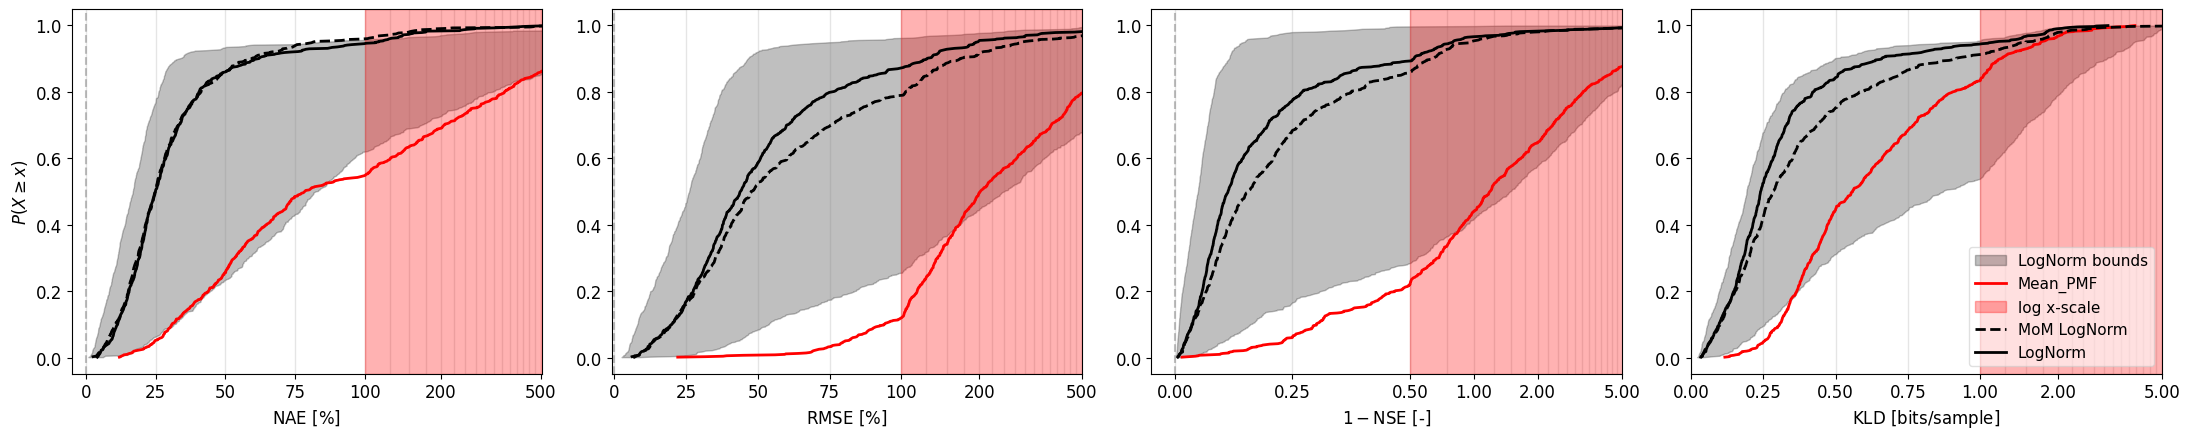

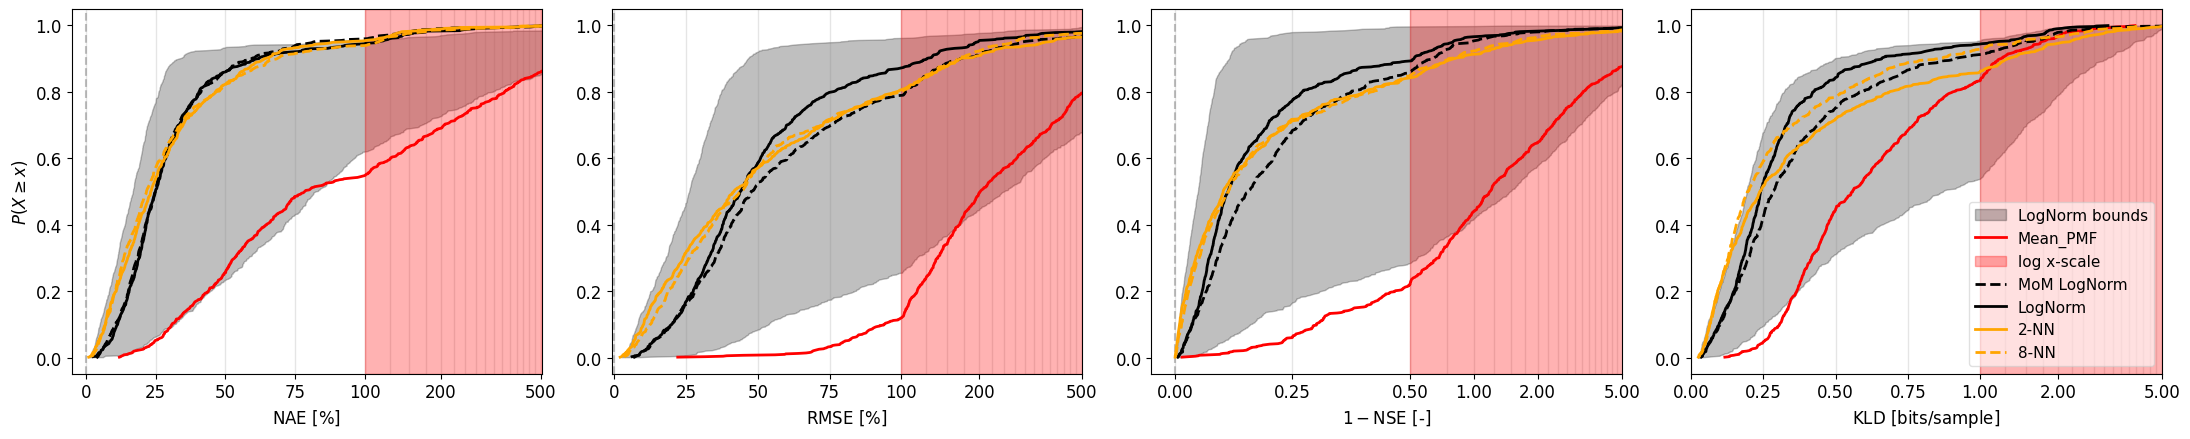

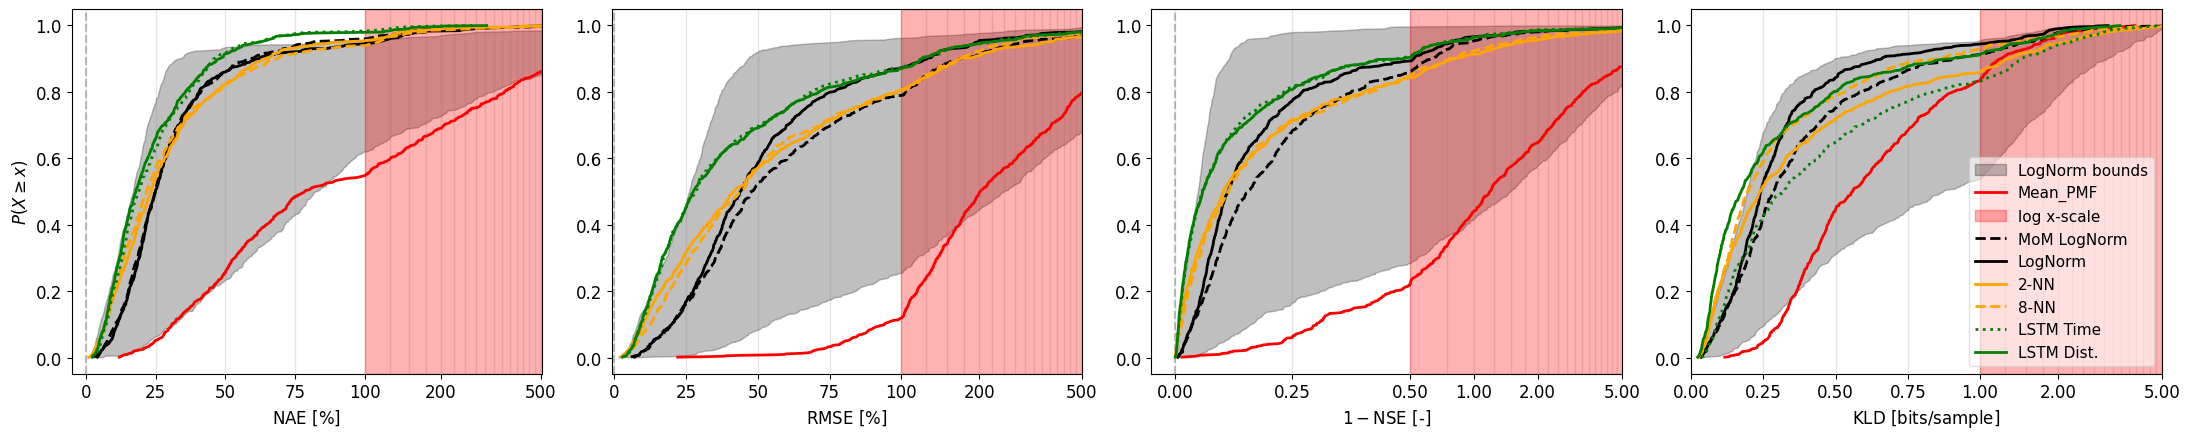

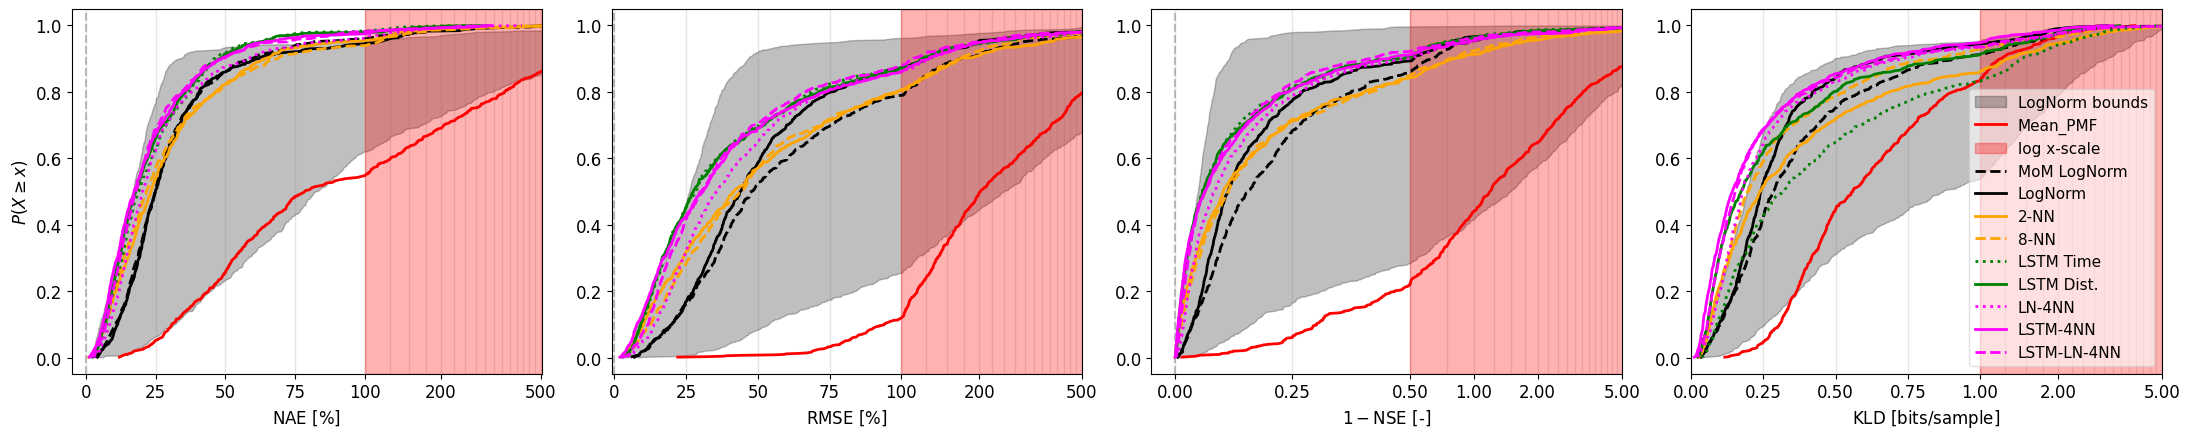

In [44]:
set_idxs = [3, 5, 7, 10]
f1 = 'parametric_results.png'
f2 = 'kNN_results.png'
f3 = 'LSTM_result_plots.png'
f4 = 'model_ensemble_results.png'
labels = [f1, f2, f3, f4]

for idx, fname in zip(set_idxs, labels):
    fig = create_model_performance_plots_matplotlib(
        plotting_metrics, plotting_axis_labels, model_specs, fdc_df, main_result_vals, idx, ncols=4,
    )
    fp = 'images/' + fname 
    fig.savefig(fp, dpi=150) 
    print(f'saved to {fp}') 

In [45]:
def fdc_panel_boxplot(all_metrics, axis_labels, model_specs, order_models):
    """Main results boxplot panel."""
    
    n_metrics = len(all_metrics)
    fig, axs = plt.subplots(1, n_metrics, figsize=(4.8 * n_metrics, 4.2), squeeze=False)
    axs = axs.ravel()
    set_ylabels = True
    for ax, dm, x_label in zip(axs, all_metrics, axis_labels):

        data_by_model = []
        labels, clrs = [], []

        for model_key, line_style, color, label in model_specs[::-1]:
            
            data, ids = load_model_data(label, model_key, dm)     

            if dm == 'NSE':
                # data = 1 - data   
                x_label = r'$$1 - \text{NSE} \text{ [-]}$$'
            elif dm == 'RB':
                x_label = r'$$\text{PB} \text{ [\%]}$$'
  
            # guard against empty arrays
            data = np.asarray(data)
            if data.size == 0 or np.all(~np.isfinite(data)):
                continue

            data_by_model.append(data[np.isfinite(data)])
            labels.append(label)
            clrs.append(color)

        # ---- plot: horizontal boxplots per model ----
        if not data_by_model:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            data_by_model, vert=False, patch_artist=True, showfliers=False, widths=0.6,
            showmeans=True, 
            boxprops=dict(linewidth=1, facecolor="#dddddd", alpha=0.8),
            meanprops=dict(marker='^', markeredgecolor='black', markerfacecolor='white', markersize=7),
            medianprops=dict(color="k", linewidth=1.2),
            whiskerprops=dict(color="0.3", linewidth=1),
            capprops=dict(color="0.3", linewidth=1)
        )

        # jittered points (optional; comment out if you don’t want them)
        rng = np.random.default_rng(0)
        for yi, vals in enumerate(data_by_model, start=1):
            jitter = (rng.random(vals.size) - 0.5) * 0.5
            c = clrs[yi - 1]
            ax.scatter(vals, yi + jitter, s=8, alpha=0.35, color=c, edgecolors="none")

        ax.set_yticklabels([''] * len(labels))  # Hide y-tick labels initially
        if set_ylabels:
            ax.set_yticks(np.arange(1, len(labels) + 1))
            ax.set_yticklabels(labels)
            set_ylabels = False

        ax.axvline(0, color="0.8", lw=1)
        ax.grid(axis="x", color="0.9", lw=0.8)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if dm  == 'NSE':
            ax.set_xlim(-0.01, 1)
            # ax.axvline(0, color="green", linestyle="--", linewidth=2)
        if dm in ['KLD']:
            # ax.set_xscale('log')
            # ax.set_xlim(1e-2, 1e1)
            ax.set_xlim(0, 2)
        elif dm == 'RB':
            ax.set_xlim(-100, 100)
            # ax.set_xlim(-1, 200)
            ax.axvline(0, color="green", linestyle="--", linewidth=2)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        elif dm == 'VE':
            ax.set_xlim(-0.01, 1.0)
            # ax.axvline(0, color="green", linestyle="--", linewidth=2)
            # ax.axvline(1, color="red", linestyle="--", linewidth=1.2)
            # create a light red shaded region for VE < 0%
            ax.axvspan(1, 1.05, color="red", alpha=0.2)
        elif dm == 'RMSE':
            ax.set_xlim(-1, 200)
            # ax.axvline(0, color="green", linestyle="--", linewidth=2)
            # ax.axvline(100, color="red", linestyle="--", linewidth=1.2)
            # create a light red shaded region for RMSE > 100%
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            # ax.axvspan(100, 200, color="red", alpha=0.2)
            # ax.set_xscale('log')
        elif dm == 'NAE':
            ax.set_xlim(-1, 105)
            # ax.axvline(0, color="green", linestyle="--", linewidth=2)
            # ax.axvline(100, color="red", linestyle="--", linewidth=1.2)
            # create a light red shaded region for NAE > 100%
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            # ax.axvspan(100, 200, color="red", alpha=0.2)
        
        if dm == 'RB':
            dm = 'PB'
        elif dm == 'NSE':
            dm = '1 - NSE'
        elif dm == 'VE':
            dm = "Normalized Absolute Error"
        ax.set_title(dm, fontsize=14)
        x_label = x_label[1:-1] 
        ax.set_xlabel(x_label)

    plt.tight_layout()
    return fig

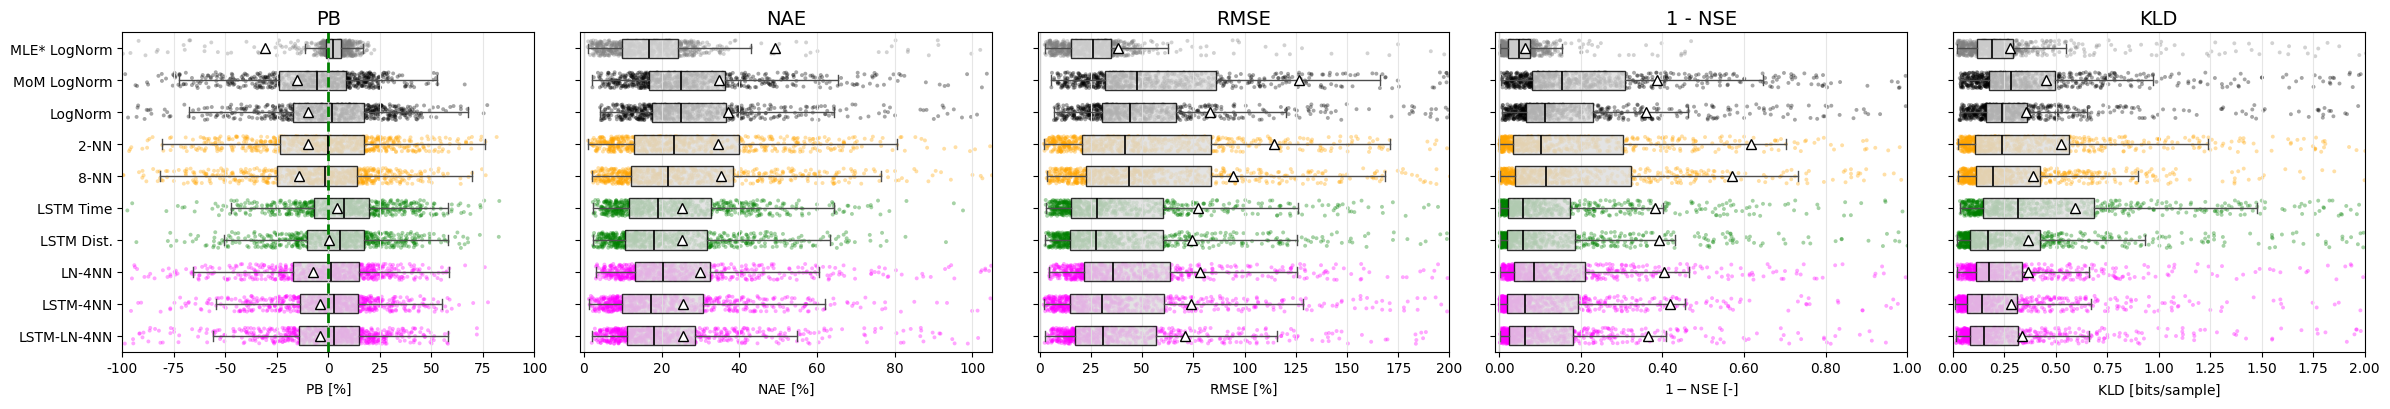

In [46]:
metric_labels = {"NSE": "NSE", "RB": "RB", "RMSE": "RMSE", "KLD": "KLD", "NAE": "NAE"}
xlims = {"NSE": (-10, 1), "RB": (-100, 100), "RMSE": (0, 500), "KLD": (0, 5), 'NAE': (0, 100)}
order_models = ['MLE', 'MoM LogNorm', 'LogNorm', '2-NN', '8-NN', 'LSTM Time', 'LSTM Dist.', 'LSTM-4NN', 'LSTM-LN-4NN.']
fig = fdc_panel_boxplot(
    ["RB", "NAE", "RMSE","NSE","KLD"], axis_labels, model_specs, order_models, 
)
plt.savefig("images/main_result_fig.png", dpi=150, bbox_inches='tight')
plt.show()

In [47]:
# create a dataframe with all the model results indexed by station
all_results = []
for m in main_result_vals.keys():
    df = main_result_vals[m].copy()
    df.rename(columns={'values': m}, inplace=True)
    if np.any(['-' in e for e in df['ids'].values]):
        df['ids'] = df['ids'].str.split('-').str[0]
    df.set_index('ids', inplace=True)
    
    all_results.append(df)
all_results_df = pd.concat(all_results, axis=1, join='inner')
print(len(all_results_df))

715


### Model variant regressions

Compare how the measures correlate within methods:

* what does the temporal vs. distribution averaging do for each metric?

In [50]:
combined_labels = [c for c in main_result_vals.keys() if (('LSTM' in c) & ('NN' in c)) | ('LN' in c)]
print(combined_labels)
LN_method_labels = [c for c in main_result_vals.keys() if ('LogNorm' in c) & (c not in combined_labels)]
print(LN_method_labels)
kNN_method_labels = [c for c in main_result_vals.keys() if ('NN' in c) & (c not in combined_labels)]
print(kNN_method_labels)
LSTM_method_labels = [c for c in main_result_vals.keys() if ('LSTM' in c) & (c not in combined_labels)]
print(LSTM_method_labels)

['LN-4NN RB', 'LSTM-4NN RB', 'LSTM-LN-4NN RB', 'LN-4NN NAE', 'LSTM-4NN NAE', 'LSTM-LN-4NN NAE', 'LN-4NN RMSE', 'LSTM-4NN RMSE', 'LSTM-LN-4NN RMSE', 'LN-4NN NSE', 'LSTM-4NN NSE', 'LSTM-LN-4NN NSE', 'LN-4NN KLD', 'LSTM-4NN KLD', 'LSTM-LN-4NN KLD']
['MLE* LogNorm RB', 'MoM LogNorm RB', 'LogNorm RB', 'MLE* LogNorm NAE', 'MoM LogNorm NAE', 'LogNorm NAE', 'MLE* LogNorm RMSE', 'MoM LogNorm RMSE', 'LogNorm RMSE', 'MLE* LogNorm NSE', 'MoM LogNorm NSE', 'LogNorm NSE', 'MLE* LogNorm KLD', 'MoM LogNorm KLD', 'LogNorm KLD']
['2-NN RB', '8-NN RB', '2-NN NAE', '8-NN NAE', '2-NN RMSE', '8-NN RMSE', '2-NN NSE', '8-NN NSE', '2-NN KLD', '8-NN KLD', '4-NN RB', '4-NN NAE', '4-NN RMSE', '4-NN NSE', '4-NN KLD']
['LSTM Time RB', 'LSTM Dist. RB', 'LSTM Time NAE', 'LSTM Dist. NAE', 'LSTM Time RMSE', 'LSTM Dist. RMSE', 'LSTM Time NSE', 'LSTM Dist. NSE', 'LSTM Time KLD', 'LSTM Dist. KLD']


In [51]:
def bootstrap_l1_slope_test(x, y, n_bootstraps=1000, alpha=0.05, delta=0.1, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(x)
    
    # Pre-generate all bootstrap indices (n_bootstraps x n)
    idxs = rng.integers(0, n, size=(n_bootstraps, n))
    
    # Pre-allocate array for slopes
    slopes = np.empty(n_bootstraps)
    
    # Loop over bootstrap samples
    x_reshaped = x.reshape(-1, 1)
    for i in range(n_bootstraps):
        xi = x_reshaped[idxs[i]]
        yi = y[idxs[i]]
        slopes[i] = l1_fit(xi.ravel(), yi)[0]

    # Confidence interval
    lower = np.percentile(slopes, 100 * alpha / 2)
    upper = np.percentile(slopes, 100 * (1 - alpha / 2))
    mean_slope = np.mean(slopes)

    # Check for meaningful difference
    is_meaningfully_different = np.abs(mean_slope - 1) > delta

    return {
        'mean_slope': float(mean_slope),
        'ci': (float(lower), float(upper)),
        'is_meaningfully_different': is_meaningfully_different,
        'bootstrapped_slopes': slopes
    }
    

def bootstrap_l2_slope_test(x, y, n_bootstraps=1000, alpha=0.05, delta=0.1, seed=None):
    """
    Perform bootstrap test on OLS slope to assess if it is meaningfully different from 1.

    Parameters:
    - x, y: 1D arrays of input data
    - n_bootstraps: number of bootstrap samples
    - alpha: significance level (e.g., 0.05 for 95% CI)
    - meaningful_diff: threshold for deviation from 1 to be considered meaningful
    - seed: optional random seed for reproducibility

    Returns:
    - dict with:
        - mean_slope: mean of bootstrap slopes
        - ci: confidence interval (lower, upper)
        - is_meaningfully_different: whether slope differs from 1 by more than `meaningful_diff`
        - bootstrapped_slopes: full array of bootstrapped slope samples
    """
    if seed is not None:
        np.random.seed(seed)

    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    n = len(x)

    slopes = np.empty(n_bootstraps)
    for i in range(n_bootstraps):
        idx = np.random.randint(0, n, n)
        xi, yi = x[idx], y[idx]
        slope, intercept, r, p, se = linregress(xi.ravel(), yi)
        slopes[i] = slope

    mean_slope = np.mean(slopes)
    lower, upper = np.percentile(slopes, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    is_meaningfully_different = (upper < 1 - delta) or (lower > 1 + delta)

    return {
        'mean_slope': float(mean_slope),
        'ci': (float(lower), float(upper)),
        'is_meaningfully_different': is_meaningfully_different,
        'bootstrapped_slopes': slopes,
    }
    

def l1_fit(x, y):
    model = QuantileRegressor(quantile=0.5, alpha=0).fit(x.reshape(-1, 1), y)
    slope = model.coef_[0]
    intercept = model.intercept_
    return slope, intercept


def symlog_transform_with_linear_region(v, lin_thresh=1):
    """Manual symlog transform: linear near 0, log beyond."""
    return np.where(np.abs(v) <= lin_thresh,
                    v,
                    np.sign(v) * (np.log(np.abs(v)) + np.log(lin_thresh)))


In [52]:
def clean_label(label, m):
    # if 'LSTM' in label:
    return label.replace('Dist', 'dist. avg.').replace('Time', 'time avg.').split(m)[0]


def plot_all_matplotlib(metrics, dataframes, units, n_rows=3, n_cols=4, font_size=12):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    def plot_loglog(ax, x, y, dm):
        # mask = (x > 1e-3) & (y > 1e-3)
        # x, y = x[mask], y[mask]
        slope, intercept, r, *_ = linregress(np.log(x), np.log(y))
        bootstrap_slope_results = bootstrap_l2_slope_test(np.log(x), np.log(y))
        for k, v in bootstrap_slope_results.items():
            if k == 'bootstrapped_slopes':
                continue
            else:
                # print(k, v)
                pass
        xx = np.linspace(np.min(x), np.max(x), 100)
        yy = np.exp(slope * np.log(xx) + intercept)
        ci_low, ci_high = bootstrap_slope_results['ci']
        yy_lower = np.exp(ci_low * np.log(xx) + intercept)
        yy_upper = np.exp(ci_high * np.log(xx) + intercept)
        
        ax.plot([x.min(), x.max()], [x.min(), x.max()], linestyle='dotted', color='black', linewidth=2.5, label='1:1')
        ax.scatter(x, y, s=5, alpha=0.6)
        band_label = f"95% CI m=[{ci_low:.2f}, {ci_high:.2f}]"
        ax.fill_between(xx, yy_lower, yy_upper, color='red', alpha=0.3, label=band_label)
        label = f'Y={slope:.2f}x + {intercept:.1f}'
        label = f'Y = exp({intercept:.2f})·X^{slope:.2f}'
        ax.plot(xx, yy, color='red', label=label, linewidth=2.5)
        ax.set_title(f'{dm}', fontsize=12)
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    def plot_symlog(ax, x, y, lin_thresh=1.):
        
        nan_x = np.sum(np.isnan(x))
        nan_y = np.sum(np.isnan(y))
        assert nan_x == 0, f'{nan_x} nan x values'
        assert nan_y == 0, f'{nan_y} nan y values'
        
        log_x = np.sign(x) * np.log(np.abs(x))
        log_y = np.sign(y) * np.log(np.abs(y))
        bootstrap_slope_results = bootstrap_l1_slope_test(log_x, log_y)
        bs_slope = bootstrap_slope_results['mean_slope']
        ci_low, ci_high = bootstrap_slope_results['ci']
                
        slope, intercept = l1_fit(log_x, log_y)
        # Sample more points around linear region
        x_lin = np.linspace(-lin_thresh, linthresh, 100)
        x_left = np.linspace(round(np.min(x), 1), -lin_thresh, 50, endpoint=False)
        x_right = np.linspace(linthresh, np.max(x), 50)

        xx = np.concatenate([x_left, x_lin, x_right])
        yy = np.exp(slope * xx + intercept)
        ax.add_patch(Rectangle((-lin_thresh, -lin_thresh), 2*lin_thresh, 2*lin_thresh,
                               facecolor='grey', alpha=0.3, zorder=0, label='linear scale'))  
        ax.plot([x.min(), x.max()], [x.min(), x.max()], linestyle='dotted', color='black', linewidth=2.5, label='1:1')
        ax.scatter(x, y, s=5, alpha=0.6) 

        ax.set_xscale('symlog', linthresh=lin_thresh)
        ax.set_yscale('symlog', linthresh=lin_thresh)      

    for ax, m, df, unit in zip(axes, metrics, dataframes, units):
        x, y = df.iloc[:, 0].values, df.iloc[:, 1].values    
        plot_loglog(ax, x, y, m)

        # ax.set_title(('MAE' if m == 'RB' else m) + f' {unit}', fontsize=font_size)
        ax.set_xlabel(clean_label(df.columns[0], m), fontsize=font_size)
        ax.set_ylabel(clean_label(df.columns[1], m), fontsize=font_size)
        ax.tick_params(labelsize=font_size - 2)
        ax.legend(fontsize=font_size - 3, framealpha=0.4)
        ax.grid(True, which='both', linestyle=':', alpha=0.5)

    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    return fig

In [53]:
def plot_all_matplotlib_linear(metrics, dataframes, units, n_rows=3, n_cols=4, font_size=12,
                    n_boot=1000, seed=0):
    """
    Simpler scatter + OLS line + bootstrap band in *linear* space.
    - metrics:   list of metric names (used only for titles)
    - dataframes:list of 2-col DataFrames [x_col, y_col]
    - units:     list of unit strings for titles
    """
    rng = np.random.default_rng(seed)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    for ax, m, df, unit in zip(axes, metrics, dataframes, units):
        # --- data ---
        x = df.iloc[:, 0].to_numpy(dtype=float)
        y = df.iloc[:, 1].to_numpy(dtype=float)
        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]

        # --- OLS fit ---
        slope, intercept, r, p, se = linregress(x, y)
        xx = np.linspace(x.min(), x.max(), 200)
        yy = slope * xx + intercept

        # --- bootstrap band (resample pairs) ---
        n = x.size
        boot_yhat = np.empty((n_boot, xx.size))
        for b in range(n_boot):
            idx = rng.integers(0, n, n)
            sb, tb = x[idx], y[idx]
            s, c, *_ = linregress(sb, tb)
            boot_yhat[b] = s * xx + c
        lo, hi = np.percentile(boot_yhat, [2.5, 97.5], axis=0)

        # --- plot ---
        ax.scatter(x, y, s=6, alpha=0.6)
        ax.plot(xx, yy, lw=2.5, label=f"y = {slope:.3f}x + {intercept:.3f}")
        ax.fill_between(xx, lo, hi, alpha=0.25, label="95% bootstrap band")

        # --- cosmetics ---
        title_metric = 'MAE' if m == 'RB' else m  # keep your existing alias if needed
        ax.set_title(f"{title_metric} {unit}", fontsize=font_size)
        ax.set_xlabel(df.columns[0], fontsize=font_size)
        ax.set_ylabel(df.columns[1], fontsize=font_size)
        ax.tick_params(labelsize=font_size - 2)
        ax.legend(fontsize=font_size - 3, framealpha=0.4)
        ax.grid(True, linestyle=":", alpha=0.5)

    # drop any unused axes
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])

    fig.tight_layout()
    return fig

In [54]:
plot_dfs = []
units = ['[%]', '[L/s/km²]', '[-]', '[bits/sample]']
units = ['[%]', '[%]', '[-]', '[bits/sample]']
for m, unit in zip(plotting_metrics, units):
    cols = list(sorted([c for c in LN_method_labels if m in c]))
    dfs = []
    for c in cols:
        data = main_result_vals[c].copy().set_index('ids')
        data.columns = [c]
        dfs.append(data)
    df = pd.concat(dfs, join='inner',axis=1)
    # if m == 'RB':
    #     df = df.map(np.abs)
    df.columns = cols
    plot_dfs.append(df)

# figs = plot_all_matplotlib(plotting_metrics, plot_dfs, units)
# figs.savefig("images/LN_mom_vs_direct_plots.png", dpi=150, bbox_inches='tight')

# plt.show()

In [55]:
plot_dfs = []
for m in all_metrics:
    cols = list(sorted([c for c in kNN_method_labels if m in c]))
    dfs = []
    for c in cols:
        data = main_result_vals[c].copy().set_index('ids')
        print(f'{c}: mean {m}={np.mean(data):.2f}')
        dfs.append(data)
    df = pd.concat(dfs, join='inner',axis=1)
    df.columns = cols
    plot_dfs.append(df)
# figs = plot_all_matplotlib(plotting_metrics, plot_dfs, units)
# figs.savefig("images/knn_8_vs_2.png", dpi=150, bbox_inches='tight')
# plt.show()

2-NN RB: mean RB=-9.90
4-NN RB: mean RB=-11.68
8-NN RB: mean RB=-14.38
2-NN NAE: mean NAE=34.42
4-NN NAE: mean NAE=33.39
8-NN NAE: mean NAE=35.25
2-NN RMSE: mean RMSE=114.53
4-NN RMSE: mean RMSE=97.35
8-NN RMSE: mean RMSE=94.50
2-NN NSE: mean NSE=0.62
4-NN NSE: mean NSE=0.59
8-NN NSE: mean NSE=0.57
2-NN KLD: mean KLD=0.52
4-NN KLD: mean KLD=0.43
8-NN KLD: mean KLD=0.39


In [56]:
plot_dfs = []
for m in all_metrics:
    # cols = list(sorted([c for c in LSTM_method_labels if m in c]))
    # cols = [c for c in cols if 'knn_lstm' not in c]
    cols = list(sorted([c for c in main_result_vals.keys() if c.startswith('LSTM')]))
    cols = [c for c in cols if c.endswith(m)]
    dfs = []
    for c in cols:
        data = main_result_vals[c].copy().set_index('ids')
        # if '-' in any of the id strings, split to keep the id which is the first index
        if np.any('-' in s for s in data.index):
            data.index = data.index.str.split('-').str[0]
        dfs.append(data)
    df = pd.concat(dfs, join='inner',axis=1)
    df.columns = cols
    plot_dfs.append(df)

# figs = plot_all_matplotlib(plotting_metrics, plot_dfs, units)
# figs.savefig('images/LSTM_time_vs_distribution_plots.png', dpi=150, bbox_inches='tight')
# plt.show()

## Rank Correlations

One interesting characteristic of the results is that about 20% of the sites can't do better than 0.4 bits/sample entropy, and that the parametric estimation is the best approach for these.  One question we can ask about this 20% is whether it's the same sample across the disparate methods, and we can figure this out directly by checking the size of the common set of ids in the worst (highest KLD/EMD) 20%.  

* are there sites that are difficult to predict, regardless of the method?
* are there methods that work better on some sites compared to others?
* are there metrics that work better on some sites compared to others?

In [57]:
def regression_scatter_plots(md, main_result_vals, plot_type='rank'):
    model_set = [e for e in main_result_vals.keys() if e.endswith(f' {md}')]
    model_set = [e for e in model_set if not e.startswith('LN MoM')]
    model_set = [e for e in model_set if not e.startswith('PredictedLMomentsGEV')]
    model_set = [e for e in model_set if 'time' not in e]
    model_set = [e for e in model_set if "MLE" not in e]
    # model_set = [e for e in model_set if '1950' not in e]
    # get unordered pairs of models
    from itertools import combinations
    model_pairs = list(combinations(model_set, 2))
    rank_scatter_plots = []
    model_labels = []
    for m1, m2 in model_pairs:
        if 'kNN' in m1 and 'kNN' in m2:
            continue
        if '3' in m1 or '3' in m2:
            continue
        # get ranking of md values and make a scatter plot
        df1 = main_result_vals[m1].copy()
        df2 = main_result_vals[m2].copy()
        if df1.empty or df2.empty:
            continue
        ascending = False if md in ['NSE', 'KGE'] else True
        df1.sort_values('values', ascending=ascending, inplace=True)
        df2.sort_values('values', ascending=ascending, inplace=True)
        df1['rank'] = np.arange(len(df1)) + 1
        df2['rank'] = np.arange(len(df2)) + 1
        # merge the two dataframes on ids
        merged = pd.merge(df1, df2, on='ids', suffixes=('_1', '_2'))
        # create a scatter plot of the ranks
        p = figure(title=f"{md}", width=350, height=300)
        if plot_type == 'rank':
            p.scatter(merged['rank_1'], merged['rank_2'], size=3)
            slope, intercept, r_value, p_value, std_err = linregress(merged['rank_1'], merged['rank_2'])
            xvals = [1, len(merged)]
            yvals = [1, len(merged)]
        else:
            p.scatter(merged['values_1'], merged['values_2'], size=3)
            slope, intercept, r_value, p_value, std_err = linregress(merged['values_1'], merged['values_2'])
            xvals = [merged['values_1'].min(), merged['values_1'].max()]
            yvals = [slope * x + intercept for x in xvals]

        p.line(xvals, yvals, line_dash='dashed', color='black', line_width=2, legend_label='1:1')
        p.line(xvals, yvals, line_color='red', line_width=2, legend_label=f'R²={r_value**2:.2f}')
        def get_plot_axis_label(m):
            if 'LN' in m:
                return 'LogNorm Direct Rank'
            elif 'LSTM' in m:
                print(m)
                return 'LSTM Rank'
            elif '9 kNN' in m:
                return '9-NN Rank'
            elif '3 kNN' in m:
                return '3-NN Rank'
            else:
                return m
        
        if plot_type == 'rank':
            x_label, y_label = get_plot_axis_label(m1), get_plot_axis_label(m2)
            p.xaxis.axis_label = x_label
            p.yaxis.axis_label = y_label
        else:
            p.xaxis.axis_label = f'{m1[:-3]} {md}'
            p.yaxis.axis_label = f'{m2[:-3]} {md}'
        if m1 not in model_labels:
            model_labels.append(m1)
        if m2 not in model_labels:
            model_labels.append(m2)
        p.legend.location = 'top_left'
        p.legend.background_fill_alpha = 0.7
        p = dpf.format_fig_fonts(p, font_size=16)
        rank_scatter_plots.append(p)
    return rank_scatter_plots, model_labels

Above: the outliers skew the meaning of the correlation between metrics from different methods.  The rank correlation is a better measure of the relationship between the methods, since it is not affected by the outliers.  

In [58]:
# define a color mapper for all correlation plots
n_colors = 10
palette = list(reversed(RdBu[n_colors]))
low, high = -0., 1.0
mapper = LinearColorMapper(palette=palette, low=low, high=high)
edges = np.linspace(low, high, n_colors + 1)
centers = [(edges[i] + edges[i+1]) / 2 for i in range(n_colors)]
# Labels to display (left edges 0.50..0.95), positioned at centers
label_map = {edges[i]: f"{edges[i]:.2f}" for i in range(len(edges))}
mapper = LinearColorMapper(palette=palette, low=low, high=high)

cbar = ColorBar(
    color_mapper=mapper,
    ticker=FixedTicker(ticks=edges),
    major_label_overrides=label_map,
    major_label_text_align="center",
    major_label_text_baseline="middle",
    label_standoff=8,            # nudge labels off the bar a bit
    padding=5,                   # bar padding inside its box
    # orientation="vertical",    # default; set "horizontal" if needed
)

In [59]:

def plot_correlation_regression(df, all_metrics, cbar, correlation_type='pearson'):
    plots = []
    
    for md in all_metrics:        
        all_models = df.columns
        model_cols = sorted([c for c in all_models if not c.startswith('MLE') and ('4NN' not in c)])
        model_cols = [c for c in model_cols if (c.endswith(f' {md}'))]

        model_df = df[model_cols].copy()

        model_df = model_df[[f'MoM LogNorm {md}', f'LogNorm {md}', f'2-NN {md}', f'8-NN {md}', f'LSTM Time {md}', f'LSTM Dist. {md}']]

        if md == 'RB': # scores nearest zero are best
            model_df = np.abs(model_df)
        
        corr_df = model_df.corr(method=correlation_type)
        # Melt correlation matrix to long-form
        corr_long = corr_df.reset_index().melt(id_vars='index')
        corr_long.columns = ['x', 'y', 'value']

        ends = corr_long['x'].str.find(md)
        corr_long['x'] = [e[:i] for e, i in zip(corr_long['x'], ends)]
        ends = corr_long['y'].str.find(md)
        corr_long['y'] = [e[:i] for e, i in zip(corr_long['y'], ends)]
        # Keep ONLY upper triangle (incl. diagonal). For lower, flip the inequality.
        x_label_idxs = [e.find(md) for e in corr_df.columns]
        x_labels = [e[:i] for e, i in zip(corr_df.columns, x_label_idxs)]
        # replace RB with MAE label
        x_labels = [e.replace('RB', 'PB') for e in x_labels]
        y_labels = list(reversed(x_labels))  # you already reverse for display

        order = {name: i for i, name in enumerate(x_labels)}
        corr_long['ix'] = corr_long['x'].map(order)
        corr_long['iy'] = corr_long['y'].map(order)

        upper_mask = corr_long['iy'] >= corr_long['ix']   # diagonal + upper triangle
        corr_long = corr_long[upper_mask].copy()
        # Create source
        source = ColumnDataSource(corr_long)
            
        w, h = 270, 300
        if len(plots) == len(all_metrics) - 1:
            w = 280
        if (len(plots) > 0) & (len(plots) < len(all_metrics) - 1):
            w = 200
        x_label_idxs = [e.find(md) for e in corr_df.columns]
        x_labels = [e[:i] for e, i in zip(corr_df.columns, x_label_idxs)]
        y_labels = list(reversed(x_labels))
        fw, fh = w, h
        if len(plots) in [1, 2, 3]:
            fw += 70
        title = 'PB' if md == 'RB' else md
        p = figure(
            frame_width=fw,
            frame_height=fh,
            title=title,
            x_range=x_labels, y_range=y_labels, toolbar_location = 'above',
            tools="hover,save",  tooltips=[("Model Pair", "@x vs @y"), ("Corr", "@value{0.2f}")]
        )
    
        p.rect(x="x", y="y", width=1, height=1, source=source,
            fill_color=transform('value', mapper), line_color=None)            
    
        if len(plots) == len(all_metrics) - 1:
            p.add_layout(cbar, 'right')

        if len(plots) > 0:
            p.yaxis.visible = False
    
        # Axis styling
        p.axis.major_label_text_font_size = "10pt"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = np.pi / 2
        p = dpf.format_fig_fonts(p, font_size=14)
        plots.append(p)
        
    return plots



In [60]:
len(all_results_df)
all_results_df.head()

,MLE* LogNorm RB,MoM LogNorm RB,LogNorm RB,2-NN RB,8-NN RB,LSTM Time RB,LSTM Dist. RB,LN-4NN RB,LSTM-4NN RB,LSTM-LN-4NN RB,...,LSTM Time KLD,LSTM Dist. KLD,LN-4NN KLD,LSTM-4NN KLD,LSTM-LN-4NN KLD,4-NN RB,4-NN NAE,4-NN RMSE,4-NN NSE,4-NN KLD
ids,,,,,,,,,,,,,,,,,,,,,
05AA008,5.640385,-0.781664,18.749270,4.699048,12.606304,19.497520,16.255768,4.895274,3.808839,9.330069,...,0.207113,0.195338,0.171247,0.160877,0.169427,-12.737620,28.515789,32.952055,0.108317,0.159033
05AA022,11.565617,24.735851,40.732282,44.194650,34.809719,30.109235,28.167589,45.813609,39.627139,40.312242,...,0.117038,0.080193,0.227090,0.124450,0.153890,49.119943,49.119943,68.804569,0.222839,0.237576
05AA023,10.114773,-7.195445,-1.516543,-34.261780,-61.955377,7.143007,4.817573,-27.019913,-23.742329,-15.498519,...,0.081735,0.028546,0.144531,0.049300,0.069780,-58.016148,58.023299,54.406965,0.176564,0.187779
05AA035,10.571329,15.961095,18.435694,-16.465321,-68.228540,-10.721598,-13.562850,-19.243516,-36.061665,-16.613175,...,0.576659,0.124542,0.141404,0.133209,0.107608,-64.265495,64.265495,64.716387,0.234884,0.212723
05AD003,10.072293,-3.859938,24.065319,0.785005,9.828280,9.463925,7.748827,20.700673,12.612311,16.707840,...,0.275367,0.094711,0.107391,0.039729,0.070210,15.652130,15.948682,34.708098,0.077966,0.110310


In [61]:
correlation_plots = plot_correlation_regression(all_results_df, all_metrics, cbar, correlation_type='kendall')
# lt = row(correlation_plots)
lt = gridplot(correlation_plots, ncols=5, toolbar_location=None)
fname = "rank_correlation_by_model"
dpf.save_fig(lt, fname)
show(lt)

Figure saved to images/rank_correlation_by_model.png


### Compute the model rank shifts by metric

Use the KL divergence as the basis.

In [62]:
def random_permutation_baseline(n):
    """Analytic baseline for mean |rank diff| between two random rankings of n items."""
    mean = n/3 - 1/(3*n)
    var  = ((n-1)*(n+1)*(n**2 + 2)) / (18 * n**2)
    std  = np.sqrt(var)
    return mean, std

def numerical_shuffling(n):
    """Numerical estimate of mean |rank diff| between two random rankings of n items."""
    n_trials = 10000
    diffs = []
    for _ in range(n_trials):
        r1 = np.random.permutation(n) + 1
        r2 = np.random.permutation(n) + 1
        diffs.append(np.mean(np.abs(r1 - r2)))
    return np.mean(diffs), np.std(diffs)

mean, std = random_permutation_baseline(len(all_results_df))
print(f'Random permutation baseline for {len(all_results_df)} items: mean={mean:.2f}, std={std:.2f}')
mean, std = numerical_shuffling(len(all_results_df))
print(f'Numerical shuffling estimate for {len(all_results_df)} items: mean={mean:.2f}, std={std:.2f}')

Random permutation baseline for 715 items: mean=238.33, std=168.53
Numerical shuffling estimate for 715 items: mean=238.44, std=5.59


In [63]:
# compute the average rank shift for each model across all metrics
# i.e. what was the average absolute difference in rank for each model by changing the evaluation metric
metric_rank_shifts = {}
metrics = ['RB', 'NAE', 'RMSE', 'NSE', 'KLD']
models  = ['MoM LogNorm', 'LogNorm', '2-NN', '8-NN', 'LSTM Dist.', 'LSTM-4NN', 'LSTM-LN-4NN']
for base_metric in metrics:
    print(f'Base metric: {base_metric}')
    for md in models:
        # print(f'   evaluating rank differences across evaluation metrics by the {md} model')
        model_cols = [c for c in all_results_df.columns if (c.startswith(md) and 'Time' not in c and '4NN' not in c)]

        min_val = round(all_results_df[f'{md} {base_metric}'].min(), 0)

        basis_rank = all_results_df[f'{md} {base_metric}'].rank(ascending=True)
        # print(f'{md} {base_metric}', min_val)
        # if base_metric == 'RB':
        #     basis_rank = all_results_df[f'{md} {base_metric}'].abs().rank(ascending=True)
        rank_diffs_df = pd.DataFrame(index=all_results_df.index)
        for metric in ['NAE', 'RMSE', 'NSE', 'KLD']:
            if metric == base_metric:
                continue
            target_col = f'{md} {metric}'
            rank_diffs_df[f'{base_metric}-{metric} diff'] = (basis_rank - all_results_df[target_col].rank(ascending=True)).abs()


Base metric: RB
Base metric: NAE
Base metric: RMSE
Base metric: NSE
Base metric: KLD


In [64]:
metrics = ['RB', 'NAE', 'RMSE', 'NSE', 'KLD']
models  = ['MoM LogNorm', 'LogNorm', '2-NN', '8-NN', 'LSTM Dist.', 'LSTM-4NN', 'LSTM-LN-4NN']

def rank_metric(s, m):
    if m == 'RB':          # closer to 0 is better
        return s.abs().rank(ascending=True)
    else:                       # RMSE, KLD lower is better
        return s.rank(ascending=True)

# unique unordered pairs
pairs = [(metrics[i], metrics[j]) for i in range(len(metrics)) for j in range(i+1, len(metrics))]

rows = []
for md in models:
    row = {}
    for a, b in pairs:
        ra = rank_metric(all_results_df[f'{md} {a}'], a)
        rb = rank_metric(all_results_df[f'{md} {b}'], b)
        diffs = (ra - rb).abs()
        mean_val = diffs.mean()
        std_val  = diffs.std()
        # Format as "mean (std)" with rounding
        row[f'{a}-{b}'] = int(round(mean_val, 0))
    rows.append({'Model': md, **row})

df_table = pd.DataFrame(rows).set_index('Model')
# add "Mean" row across models, computing mean and std of the mean values
mean_row = {}
for col in df_table.columns:
    # extract numeric part from each cell for mean/std across models
    nums = df_table[col].values
    mean_row[col] = f"{np.mean(nums):.0f} ± {np.std(nums):.0f}"
df_table.loc['Mean'] = mean_row

# export to LaTeX
latex_str = df_table.to_latex(
    escape=False,   # allow parentheses and spaces
    multicolumn=False,
    caption='Average absolute rank shift (mean with stdev in brackets) per model and metric pair.',
    label='tab:avg-rank-shift-mean-std',
    bold_rows=True
)

print(latex_str)

\begin{table}
\caption{Average absolute rank shift (mean with stdev in brackets) per model and metric pair.}
\label{tab:avg-rank-shift-mean-std}
\begin{tabular}{lllllllllll}
\toprule
 & RB-NAE & RB-RMSE & RB-NSE & RB-KLD & NAE-RMSE & NAE-NSE & NAE-KLD & RMSE-NSE & RMSE-KLD & NSE-KLD \\
Model &  &  &  &  &  &  &  &  &  &  \\
\midrule
\textbf{MoM LogNorm} & 97 & 153 & 147 & 173 & 100 & 107 & 125 & 62 & 75 & 92 \\
\textbf{LogNorm} & 84 & 131 & 146 & 177 & 91 & 118 & 137 & 73 & 107 & 127 \\
\textbf{2-NN} & 54 & 127 & 131 & 154 & 99 & 102 & 128 & 51 & 91 & 112 \\
\textbf{8-NN} & 55 & 140 & 145 & 166 & 111 & 117 & 137 & 55 & 92 & 115 \\
\textbf{LSTM Dist.} & 62 & 125 & 129 & 159 & 91 & 99 & 126 & 48 & 90 & 108 \\
\textbf{LSTM-4NN} & 61 & 137 & 139 & 159 & 98 & 105 & 126 & 48 & 89 & 103 \\
\textbf{LSTM-LN-4NN} & 63 & 130 & 136 & 158 & 96 & 107 & 126 & 54 & 85 & 107 \\
\textbf{Mean} & 68 ± 15 & 135 ± 9 & 139 ± 7 & 164 ± 8 & 98 ± 6 & 108 ± 7 & 129 ± 5 & 56 ± 8 & 90 ± 9 & 109 ± 10 \\
\bottomrule

## Examine how ranks change between metrics

We have seen how the rank correlations compare between methods for the same metric, and this tells us that some methods are complementary, that is they may capture different aspects of the data or model performance. Another perspective is to look at how the ranks change by metric, in other words to see where metrics agree and disagree about the relative performance of methods.


In [65]:
from bokeh.models.formatters import CustomJSTickFormatter

def plot_correlation_regression(df, models, all_metrics, cbar, correlation_type='pearson'):
    plots = []
    for md in models:#, 'LSTM-4NN', 'LSTM-LN-4NN']:
        model_cols = [c for c in df.columns if (md in c) and 'Time' not in c and 'MoM' not in c and 'MLE' not in c]
        model_df = df[model_cols].copy()
        rb_col = [f for f in model_cols if f.endswith('RB')]
        if rb_col:
            # rename to PB for display
            model_df.rename(columns={rb_col[0]: rb_col[0].replace('RB', 'PB')}, inplace=True)
            model_cols = [c.replace('RB', 'PB') if c.endswith('RB') else c for c in model_cols]
            # rank by absolute value for RB/PB
            model_df[model_cols] = model_df[model_cols].abs()
        assert model_cols, df.columns

        corr_df = model_df[model_cols].corr(method=correlation_type)

        if correlation_type == 'kendall':
            label = 'Kendall Tau Correlation'
        elif correlation_type == 'pearson':
            label = 'Pearson Correlation'
        else:
            raise ValueError(f"Unsupported correlation type: {correlation_type}")
        
        # Melt correlation matrix to long-form
        corr_long = corr_df.reset_index().melt(id_vars='index')
        # print(corr_df)
        corr_long.columns = ['x', 'y', 'value']

        # Keep ONLY upper triangle (incl. diagonal). For lower, flip the inequality.
        # x_label_idxs = [e for e in corr_df.columns]
        x_labels = [e for e in corr_df.columns]
        # replace RB with MAE label
        y_labels = list(reversed(x_labels))  # you already reverse for display

        order = {name: i for i, name in enumerate(x_labels)}
        corr_long['ix'] = corr_long['x'].map(order)
        corr_long['iy'] = corr_long['y'].map(order)

        upper_mask = corr_long['iy'] >= corr_long['ix']   # diagonal + upper triangle
        corr_long = corr_long[upper_mask].copy()
        # Create source
        source = ColumnDataSource(corr_long)
    
        # low, high = 0.1, 1.0
        # min_val = min(corr_long['value'].min(), 0.1)

        # Optional: format labels as strings with 2 decimals
        w, h = 270, 300
        if len(plots) == len(all_metrics) - 1:
            w = 280
        if (len(plots) > 0) & (len(plots) < len(all_metrics) - 1):
            w = 200
        # replace RB with MAE label
        y_labels = list(reversed(x_labels))
        fw, fh = w, h
        if len(plots) in [1, 2]:
            fw += 70
        
        p = figure(
            frame_width=fw,
            frame_height=fh,
            title=md,
            x_range=x_labels, y_range=y_labels, toolbar_location = 'above',
            tools="hover,save",  tooltips=[("Model Pair", "@x vs @y"), ("Corr", "@value{0.2f}")]
        )
    
        p.rect(x="x", y="y", width=1, height=1, source=source,
            fill_color=transform('value', mapper), line_color=None)            
    
        if len(plots) == len(models) - 1:
            p.add_layout(cbar, 'right')

        if len(plots) > 0:
            p.yaxis.visible = False        
    
        # Axis styling
        p.axis.major_label_text_font_size = "10pt"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = np.pi / 2
        p = dpf.format_fig_fonts(p, font_size=14)

        # label_map = {label: label.split(" ")[-1] for label in y_labels}
        p.yaxis[0].formatter = CustomJSTickFormatter(code="""
            const s = String(tick);
            const i = s.lastIndexOf(' ');
            return i >= 0 ? s.slice(i+1) : s;
        """)
        p.xaxis[0].formatter = CustomJSTickFormatter(code="""
            const s = String(tick);
            const i = s.lastIndexOf(' ');
            return i >= 0 ? s.slice(i+1) : s;
        """)
        plots.append(p)
        
    return plots


In [66]:
models = ['LogNorm', '8-NN', 'LSTM Dist']
correlation_plots = plot_correlation_regression(all_results_df, models, all_metrics, cbar, correlation_type='kendall')
lt = gridplot(correlation_plots, ncols=4, toolbar_location=None)
fname = "rank_correlation_by_metric"
dpf.save_fig(lt, fname)
show(lt)

Figure saved to images/rank_correlation_by_metric.png


Rank correlation between metrics within a model tell us whether different metrics agree on which catchments are "easiest" and which are "hardest" to model.  This is about evaluation objectives, not about propriety of the metric.

### Compute the distribution of rank changes by metric


In [67]:
rank_df = all_results_df.copy()
rank_diffs = {}
abs_rank_diffs = {}

for m in ['LogNorm', '8-NN', 'LSTM']:

    cols = [c for c in all_results_df.columns if m in c and 'Time' not in c and '4NN' not in c and 'MoM' not in c and '2-NN' not in c]

    if m == 'RB':
        # for RB, values close to zero are best
        rank_df[cols] = np.abs(rank_df[cols])

    rank_df[cols] = rank_df[cols].rank(ascending=True, method='min')
    kld_col = [c for c in cols if 'KLD' in c]
    other_cols = [c for c in cols if c not in kld_col]
    for c in other_cols:
        # Compute the differences in rank between this column and the KLD column
        rank_diffs[f'{c}'] = (rank_df[c] - rank_df[kld_col[0]]).values
        abs_rank_diffs[f'{c}'] = np.abs(rank_df[c] - rank_df[kld_col[0]]).values
        print(f'{c}')     

rank_data = pd.DataFrame(rank_diffs, index=all_results_df.index)
abs_rank_diffs_data = pd.DataFrame(abs_rank_diffs, index=all_results_df.index)
print("Rank differences compared to KLD:")
print("Absolute rank differences compared to KLD:")
# abs_rank_diffs_data.describe()

MLE* LogNorm RB
LogNorm RB
MLE* LogNorm NAE
LogNorm NAE
MLE* LogNorm RMSE
LogNorm RMSE
MLE* LogNorm NSE
LogNorm NSE
8-NN RB
8-NN NAE
8-NN RMSE
8-NN NSE
LSTM Dist. RB
LSTM Dist. NAE
LSTM Dist. RMSE
LSTM Dist. NSE
Rank differences compared to KLD:
Absolute rank differences compared to KLD:


In [68]:
p = figure(title=f"Rank Differences: {dm} vs KLD", width=800, height=400)
lines = ['solid', 'dashed', 'dotted', 'dotdash']
for i, dm in enumerate(['RB', 'NAE', 'RMSE', 'NSE']):
    line = lines[i]
    rd = rank_data.copy()[[c for c in rank_data.columns if dm in c]]
    for i, c in enumerate(rd.columns):
        # plot a box plot of the rank differences for each model
        v = rd[c].values
        x, y = compute_empirical_cdf(v)
        p.line(x, y, legend_label=c, line_width=2, color=Bokeh4[i], line_dash=line)

    
p.legend.location='top_left'
p.legend.click_policy="hide"
p = dpf.format_fig_fonts(p, font_size=14)
# show(p)


### Plot example rank scatter plots

In [69]:
plots = []
for m in ['LogNorm', '8-NN', 'LSTM']:
    cols = sorted([c for c in rank_data.columns if m in c and 'Time' not in c and '4NN' not in c and 'MoM' not in c and '2-NN' not in c])
    print(cols)
    
    for i in [0, 1]:
        c1, c2 = cols[i].split(' ')[-1], cols[i + 1].split(' ')[-1]
        p = figure(title=f"{m}: {c1} vs {c2} rank diffs vs. KLD")
        df = rank_data[[cols[i], cols[i+1]]].dropna(how='any').copy()
        # rank the values
        df = df.rank(ascending=True, method='min')
        x, y = df[cols[i]].values, df[cols[i+1]].values
        p.scatter(x, y, size=3, alpha=0.6, color='dodgerblue')
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        xvals = [df[cols[i]].min(), df[cols[i]].max()]
        yvals = [slope * x + intercept for x in xvals]
        p.line(xvals, yvals, line_dash='dashed', color='red', line_width=2, legend_label=f'R²={r_value**2:.2f}')
        p.line(xvals, xvals, line_color='black', line_dash='dotted', line_width=3, legend_label='1:1')
        p.xaxis.axis_label = f'{c1} - DKL'
        p.yaxis.axis_label = f'{c2} - DKL'
        p.legend.location = 'top_left'
        p.legend.background_fill_alpha = 0.7
        p = dpf.format_fig_fonts(p, font_size=16)
        plots.append(p)
    
lt = gridplot(plots, ncols=2, width=400, height=300)
show(lt)

['LogNorm NAE', 'LogNorm NSE', 'LogNorm RB', 'LogNorm RMSE', 'MLE* LogNorm NAE', 'MLE* LogNorm NSE', 'MLE* LogNorm RB', 'MLE* LogNorm RMSE']
['8-NN NAE', '8-NN NSE', '8-NN RB', '8-NN RMSE']
['LSTM Dist. NAE', 'LSTM Dist. NSE', 'LSTM Dist. RB', 'LSTM Dist. RMSE']


The next sets of plots represent different ways to control the preservation of information in the kNN method:

1.  Look across k neighbours for the same method of selecting neighbours (e.g., IDW, CAS, etc.) to see how the kNN method performs as a function of k.  This will help us understand the trade-off between the number of neighbours and the performance of the kNN method.



### Compare the sensitivity to metrics to the estimation performance

Given the range of sensitivity expressed in the distributions above to sampling variability, to the choice of quantization, and to the edge trimming of the percentile range, we can compare the worst predicted FDCs to the sensitivity of the metrics on the reference distribution. 

In [70]:
M = 9 # our quantization is to 2^10 = 1024 bins (states)
eps = 1e-3
B = 1000

spaces = {
    'log':    (lambda v: v,          'log-units'),      # additive in log
    'linear': (np.exp,               'L/s/km²'),        # additive in linear units (volume meaning)
}
all_results_dict = {}
for m in [8, 10]:
    all_results_dict[m] = {e:{} for e in [1e-3, 1e-2]}
    for eps in [1e-3, 1e-2]:
        residuals_fpath = os.path.join('data', 'results', 'quantization_sensitivity', f'quantization_residuals_bootstrapped_{m}_bits_{str(eps)}_eps.csv')
        print(f'   Loading existing results from {residuals_fpath}')
        results_df = pd.read_csv(residuals_fpath, index_col=0, dtype={'official_id': str})
        all_results_dict[m][eps] = results_df

   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_8_bits_0.001_eps.csv
   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_8_bits_0.01_eps.csv
   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_10_bits_0.001_eps.csv
   Loading existing results from data/results/quantization_sensitivity/quantization_residuals_bootstrapped_10_bits_0.01_eps.csv


In [71]:
def plot_all_metrics_boxplots(results_dict, all_metrics):
    n_metrics = len(all_metrics)
    fig, axes = plt.subplots(
        1, n_metrics,
        figsize=(5 * n_metrics, 6),
        sharey=False, 
    )
    lim_dict = {
        'RB': (-50, 50),
        'NAE': (-40, 40),
        'RMSE': (-80, 60),
        'NSE': (-0.5, 0.5),
        'KLD': (-0.4, 0.4),
    }

    if n_metrics == 1:
        axes = [axes]

    rng = np.random.default_rng(0)
    nn = 0
    for ax, m in zip(axes, all_metrics):
        xmin, xmax = lim_dict[m]
        score_changes_df = results_dict[m]
        cols = score_changes_df.columns
        y = np.arange(1, len(cols) + 1)

        # Horizontal boxplots
        bp = ax.boxplot(
            [score_changes_df[c].dropna().values for c in cols],
            positions=y,
            whis=1.5,
            vert=False,
            widths=0.6,
            patch_artist=True,
            showfliers=False,
        )

        # Style
        for box in bp['boxes']:
            box.set_alpha(0.8)
            box.set_color('black')
            box.set_facecolor('white')
        for median in bp['medians']:
            median.set_linewidth(2.0)
            median.set_color('black')

        # Jittered points (horizontal)
        jitter = 0.12
        for yi, c in zip(y, cols):
            vals = score_changes_df[c].dropna().values
            ax.scatter(
                vals,
                yi + rng.normal(0, jitter, size=vals.size),
                s=12,
                alpha=0.5,
                linewidths=0
            )

        # Reference line at 0
        ax.axvline(0, linestyle="--", color="k", linewidth=1)

        # Labels
        ax.set_yticks(y)
        ax.set_yticklabels([e.upper() for e in cols], size=12)
        # set the x-limits
        ax.set_xlim(xmin, xmax)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)

        ax.set_title(m, size=14)
        nn += 1
        if nn > 1:
            ax.set_yticklabels([])

    # fig.text(0.5, 0.04, "Change in score (ensemble − component)", ha="center")
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    return fig, axes

In [72]:
# compare the change in performance from the individual model to the ensemble model
score_changes = {}
plots = []
for m in all_metrics:
    p = figure(title=f"{m}", width=800, height=400)
    p2, k4, lstm2 = f'LogNorm {m}', f'4-NN {m}', f'LSTM Dist. {m}'
    ln4nn = f'LN-4NN {m}'
    l24nn = f'LSTM-4NN {m}'
    l2ln4nn = f'LSTM-LN-4NN {m}'
    changes = {
        'p2-4nn_p2': (all_results_df[ln4nn] - all_results_df[p2]).values,
        'p2-4nn_4nn': (all_results_df[ln4nn] - all_results_df[k4]).values,
        'l2-4nn_l2': (all_results_df[l24nn] - all_results_df[lstm2]).values,
        'l2-4nn_4nn': (all_results_df[l24nn] - all_results_df[k4]).values,
        'l2-p2-4nn_l2': (all_results_df[l2ln4nn] - all_results_df[lstm2]).values,
        'l2-p2-4nn_p2': (all_results_df[l2ln4nn] - all_results_df[p2]).values,
        'l2-p2-4nn_4nn': (all_results_df[l2ln4nn] - all_results_df[k4]).values
    }
    score_changes_df = pd.DataFrame(changes)
    score_changes[m] = score_changes_df


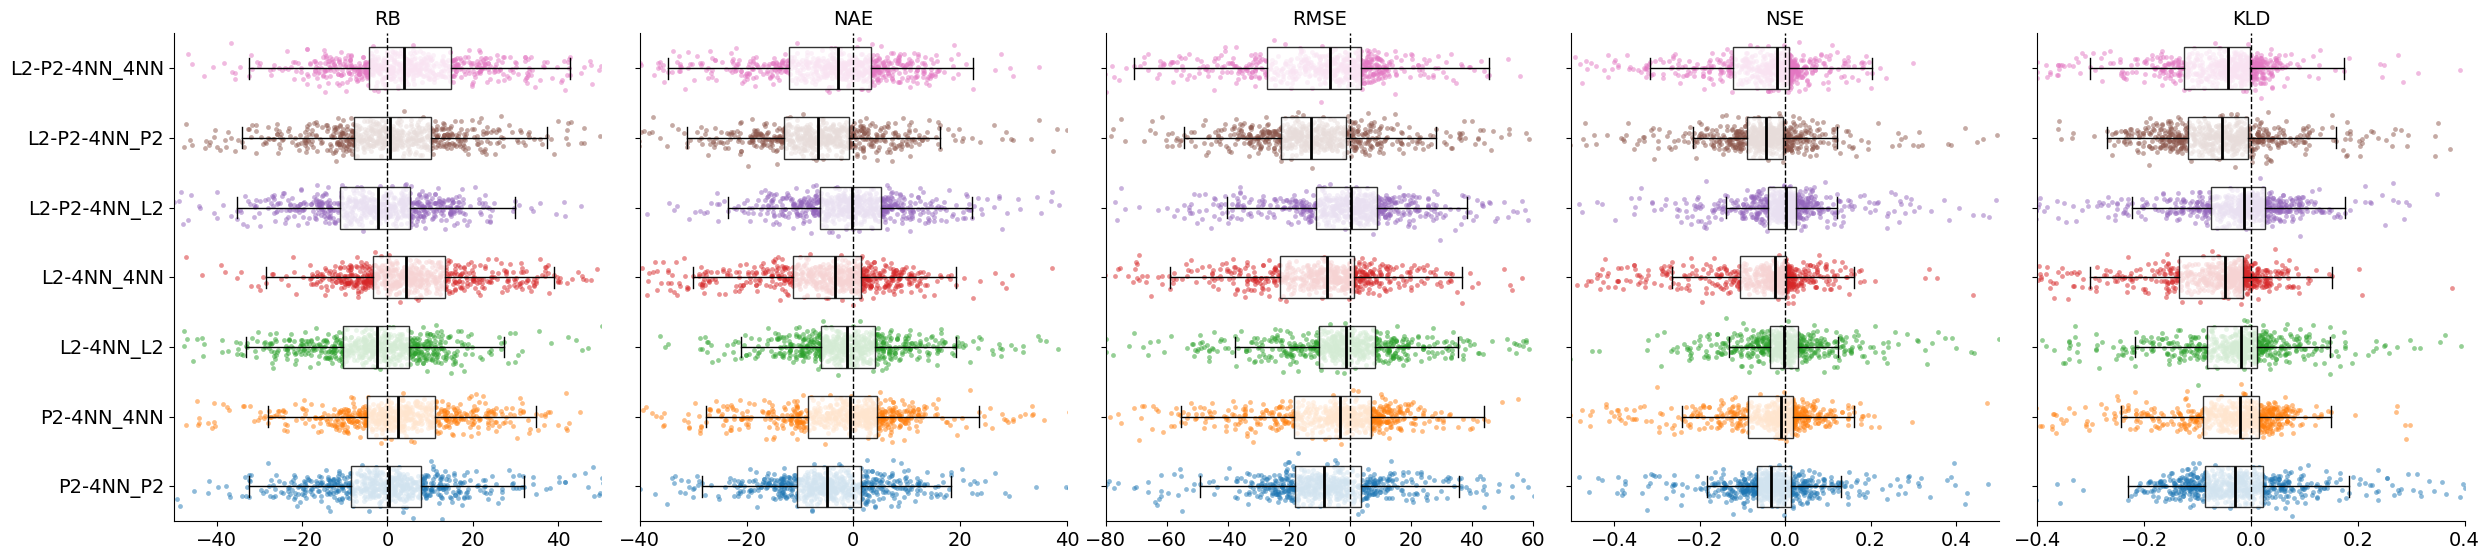

In [233]:
fig, axes = plot_all_metrics_boxplots(score_changes, all_metrics)
fname = f'ensemble_model_score_changes_boxplots'
fig.savefig(f'images/{fname}.png', dpi=150, bbox_inches='tight')

### Model Failure Analysis

How often do the models fail to beat the "null" models?  If a catchment fails by one metric, is it likely to fail by others?  Is one metric more likely to produce failures? 

In [74]:
# foo = all_results_df[[c for c in all_results_df.columns if c.endswith('RMSE')]].copy()
failures = {'RMSE': 0, 'NSE': 0, 'KLD': 0, 'NAE': 0}
fail_dfs = []
stn_fail_dict = {'RMSE': [], 'NSE': [], 'KLD': [], 'NAE': []}
for m in failures.keys():
    uniform_scores = fdc_df.loc[fdc_df['Label'] == 'Uniform', ['Official_ID', m]].set_index('Official_ID')
    mean_pmf_scores = fdc_df.loc[fdc_df['Label'] == 'Mean_PMF', ['Official_ID', m]].set_index('Official_ID')
    randomDraw_scores = fdc_df.loc[fdc_df['Label'] == 'RandomDraw', ['Official_ID', m]].set_index('Official_ID')
    metric_cols = sorted([c for c in all_results_df.columns if c.endswith(m)])
    print(m)
    fail_pcts, model_labels = [], []
    for model in metric_cols:
        model_scores = all_results_df[[model]].copy()
        combined = pd.concat([model_scores, uniform_scores, mean_pmf_scores, randomDraw_scores], 
                             axis=1, join='inner')
        combined.columns = [model, 'Uniform', 'Mean_PMF', 'RandomDraw']


        if m == 'RB':
            # find all rows where RB is worse than uniform (i.e. abs(RB_model) > abs(RB_uniform))
            fails = combined[
                (np.abs(combined[model]) > np.abs(combined[['Uniform', 'Mean_PMF', 'RandomDraw']]).min(axis=1))
            ]
        elif m == 'NSE':
            max_nse = combined[model].max()
            fails = combined[combined[model] < 0]
            if max_nse > 1:
                fails = combined[combined[model] > 1]
        else:
            # Check if the model column is worse than any of the benchmark columns, row-wise
            fails = combined[
                (combined[model] > combined[['Uniform', 'Mean_PMF', 'RandomDraw']].min(axis=1))
            ]

        n_fails = len(fails)
        fail_pcts.append(n_fails / len(combined) * 100)
        model_labels.append(model.split(m)[0])
        print(f'    {model} has {n_fails} failures out of {len(combined)} stations. ({n_fails/715*100:.0f}%)')
        
        fail_stns = fails.index.values
        for stn in fail_stns:
            stn_fail_dict[m].append(stn)
    fail_df = pd.DataFrame({'model': model_labels, m: fail_pcts})
    fail_dfs.append(fail_df.set_index('model'))

    print('')

failure_df = pd.concat(fail_dfs, axis=1).round(0).astype(int)
failure_df.to_latex()

metric_fail_counts = {}
for model, failed_stns in stn_fail_dict.items():
    # get the stations that failed for this model
    for stn in list(set(failed_stns)):
        if stn not in metric_fail_counts:
            metric_fail_counts[stn] = 0
        metric_fail_counts[stn] += 1
fail_count_df = pd.DataFrame.from_dict(metric_fail_counts, orient='index', columns=['n_failed_metrics'])
fail_count_df.sort_values(by='n_failed_metrics', ascending=False, inplace=True)
for i in range(1, 5):
    n_stns = len(fail_count_df[fail_count_df['n_failed_metrics'] == i])
    print(f'{n_stns} stations ({100*n_stns/715:.0f}%) failed {i} metrics.')

RMSE
    2-NN RMSE has 116 failures out of 715 stations. (16%)
    4-NN RMSE has 102 failures out of 715 stations. (14%)
    8-NN RMSE has 99 failures out of 715 stations. (14%)
    LN-4NN RMSE has 73 failures out of 715 stations. (10%)
    LSTM Dist. RMSE has 70 failures out of 715 stations. (10%)
    LSTM Time RMSE has 62 failures out of 715 stations. (9%)
    LSTM-4NN RMSE has 65 failures out of 715 stations. (9%)
    LSTM-LN-4NN RMSE has 61 failures out of 715 stations. (9%)
    LogNorm RMSE has 83 failures out of 715 stations. (12%)
    MLE* LogNorm RMSE has 3 failures out of 715 stations. (0%)
    MoM LogNorm RMSE has 125 failures out of 715 stations. (17%)

NSE
    2-NN NSE has 62 failures out of 715 stations. (9%)
    4-NN NSE has 56 failures out of 715 stations. (8%)
    8-NN NSE has 55 failures out of 715 stations. (8%)
    LN-4NN NSE has 32 failures out of 715 stations. (4%)
    LSTM Dist. NSE has 26 failures out of 715 stations. (4%)
    LSTM Time NSE has 25 failures out of

### Format a results table

In [81]:
def format_latex_table(df, all_models, metrics):
    # Initialize a list to store rows of the LaTeX table
    table_rows = []

    # Define the models and metrics we want to extract
    # Loop through each model and metric to format the table
    for model in all_models:
        row = [model]  # Start row with the model name
        for m in metrics:
            metric_cols = [c for c in df.columns if c.endswith(m)]
            metric_data = df[metric_cols].copy()
            label = f'{model}{m}'
            assert label in df.columns, f'{label} not in columns'
            if m == 'NSE':
                nse_col = [c for c in metric_cols if c.endswith('NSE')][0]
                max_val = metric_data[nse_col].max()
                if max_val > 1:
                    metric_data[nse_col] = 1 - metric_data[nse_col]
            if model.startswith('MLE') and m == 'NSE':
                metric_data[f'{model}{m}'] = 1 - metric_data[f'{model}{m}']
            # elif m == 'RB':
            #     # make values absolute for RB
            #     metric_data[label] = np.abs(metric_data[label])
            
            mean = metric_data[label].mean()
            median = metric_data[label].median()
            lower, upper = np.percentile(metric_data[label], [2.5, 97.5])

            best_val = False
            if np.abs(mean) == abs(metric_data.mean()).min():
                print('best val', label, round(mean, 2))
                best_val = True 
            
            # Format the mean to 1 decimal place and the CI as a tuple
            mean_formatted = f"{mean:.1f}, {median:.1f}"
            ci_formatted = f"({lower:.1f}, {upper:.1f})"
            if m in ['RB', 'RMSE', 'NAE']:
                mean_formatted = f"{mean:.0f}, {median:.0f}"
                ci_formatted = f"({lower:.0f}, {upper:.0f})"
            elif m in ['KLD', 'NSE']:
                mean_formatted = f"{mean:.2f}, {median:.2f}"
                ci_formatted = f"({lower:.2f}, {upper:.1f})"
            else:
                mean_formatted = f"{mean:.2f}, {median:.2f}"
                ci_formatted = f"({lower:.2f}, {upper:.2f})"

            formatted_row = f"**{mean_formatted} {ci_formatted}**" if best_val else f"{mean_formatted} {ci_formatted}"
            # Append the formatted values as a single entry (mean and CI together)
            row.append(formatted_row)

        # Append the completed row to the table rows list
        table_rows.append(row)
    
    # Create a DataFrame from the table rows for easy formatting
    table_df = pd.DataFrame(table_rows, columns=["Model"] + 
                            [f"{metric}" for metric in metrics])

    # Now convert this DataFrame into LaTeX table format
    # print(table_df)
    latex_table = table_df.to_latex(index=False, escape=False)
    # latex_table = table_df.to_markdown(index=False)
    
    return latex_table

In [82]:
all_models = ['MLE* LogNorm ', 'MoM LogNorm ', 'LogNorm ', '8-NN ', '2-NN ', 'LSTM Time ', 'LSTM Dist. ', 'LN-4NN ', 'LSTM-4NN ', 'LSTM-LN-4NN '] 
print(all_results_df.columns)

tb = format_latex_table(all_results_df, all_models, all_metrics)
tb

Index(['MLE* LogNorm RB', 'MoM LogNorm RB', 'LogNorm RB', '2-NN RB', '8-NN RB',
       'LSTM Time RB', 'LSTM Dist. RB', 'LN-4NN RB', 'LSTM-4NN RB',
       'LSTM-LN-4NN RB', 'MLE* LogNorm NAE', 'MoM LogNorm NAE', 'LogNorm NAE',
       '2-NN NAE', '8-NN NAE', 'LSTM Time NAE', 'LSTM Dist. NAE', 'LN-4NN NAE',
       'LSTM-4NN NAE', 'LSTM-LN-4NN NAE', 'MLE* LogNorm RMSE',
       'MoM LogNorm RMSE', 'LogNorm RMSE', '2-NN RMSE', '8-NN RMSE',
       'LSTM Time RMSE', 'LSTM Dist. RMSE', 'LN-4NN RMSE', 'LSTM-4NN RMSE',
       'LSTM-LN-4NN RMSE', 'MLE* LogNorm NSE', 'MoM LogNorm NSE',
       'LogNorm NSE', '2-NN NSE', '8-NN NSE', 'LSTM Time NSE',
       'LSTM Dist. NSE', 'LN-4NN NSE', 'LSTM-4NN NSE', 'LSTM-LN-4NN NSE',
       'MLE* LogNorm KLD', 'MoM LogNorm KLD', 'LogNorm KLD', '2-NN KLD',
       '8-NN KLD', 'LSTM Time KLD', 'LSTM Dist. KLD', 'LN-4NN KLD',
       'LSTM-4NN KLD', 'LSTM-LN-4NN KLD', '4-NN RB', '4-NN NAE', '4-NN RMSE',
       '4-NN NSE', '4-NN KLD'],
      dtype='object')
best val 

'\\begin{tabular}{llllll}\n\\toprule\nModel & RB & NAE & RMSE & NSE & KLD \\\\\n\\midrule\nMLE* LogNorm  & -31, 2 (-211, 16) & 49, 17 (3, 231) & **38, 26 (5, 177)** & **0.06, 0.05 (0.00, 0.2)** & **0.28, 0.19 (0.03, 1.4)** \\\\\nMoM LogNorm  & -15, -5 (-128, 35) & 35, 25 (6, 133) & 127, 48 (12, 638) & 0.39, 0.15 (0.02, 1.6) & 0.45, 0.28 (0.05, 1.9) \\\\\nLogNorm  & -10, 2 (-150, 45) & 37, 25 (6, 151) & 83, 44 (11, 345) & **0.36, 0.11 (0.02, 1.4)** & 0.35, 0.24 (0.05, 1.8) \\\\\n8-NN  & -14, -2 (-144, 46) & 35, 22 (4, 145) & 95, 44 (6, 461) & 0.57, 0.11 (0.00, 2.7) & 0.39, 0.20 (0.04, 2.3) \\\\\n2-NN  & -10, -0 (-132, 57) & 34, 23 (3, 132) & 115, 42 (5, 661) & 0.62, 0.10 (0.00, 3.4) & 0.52, 0.24 (0.04, 2.9) \\\\\nLSTM Time  & 4, 8 (-66, 52) & 25, 19 (5, 74) & 77, 28 (6, 400) & 0.38, 0.06 (0.00, 1.2) & 0.59, 0.32 (0.06, 2.9) \\\\\nLSTM Dist.  & **0, 6 (-76, 49)** & **25, 18 (4, 77)** & 75, 28 (6, 433) & 0.39, 0.06 (0.00, 1.4) & 0.36, 0.17 (0.04, 2.0) \\\\\nLN-4NN  & -8, 2 (-121, 45) & 30

## Check the percent change in land cover over 2010 to 2020 compared to the error metrics

In [83]:
bcub_attrs_fname = Path('data') / 'BCUB_watershed_attributes_updated_20250227.csv'
bcub_df = pd.read_csv(bcub_attrs_fname, dtype={'official_id': str, 'watershed_id': str})
bcub_df = bcub_df[[c for c in bcub_df.columns if c not in ['Unnamed: 0']]]


In [84]:
bcub_df['forest_change'] = bcub_df['land_use_forest_frac_2010'] - bcub_df['land_use_forest_frac_2020']
bcub_df['ice_change'] = bcub_df['land_use_snow_ice_frac_2010'] - bcub_df['land_use_snow_ice_frac_2020']
bcub_df['water_change'] = bcub_df['land_use_water_frac_2010'] - bcub_df['land_use_water_frac_2020']

In [85]:
# plot the distribution of change values:
f = figure(title=f'Distribution of land cover change (2010-2020)', width=600, height=400)
for i, s in enumerate(['forest_change', 'ice_change', 'water_change']):
    x, y = compute_empirical_cdf(bcub_df[s].values)
    f.line(x, y, line_width=2, color=Bokeh6[2*i], legend_label=s)
f.xaxis.axis_label = '% change'
f.yaxis.axis_label = 'P(x)'
f.legend.location = 'top_left'
f.legend.click_policy = 'hide'
f = dpf.format_fig_fonts(f, font_size=14)
show(f)

In [86]:
# plot a correlation between land cover change and the DKL/EMD values
# models = list(main_result_vals.keys())
figs = []
for dm in all_metrics:
    f = figure(title=f'Correlation between land cover change and {dm}', width=600, height=400, y_axis_type='log')
    # models = [m for m in models if m.endswith(f'_{dm}')]
    models = [f'PredictedLog_{dm}', f'kNN1980_{dm}', f'LSTM_freq_{dm}'] 
    for i, model in enumerate(models):    
        # 'LN MoM KLD', 'LN Direct KLD', '3 kNN KLD', '9 kNN KLD', 'LSTM time KLD', 'LSTM freq KLD'
        data = main_result_vals[f'LSTM Dist. {dm}'].copy()
        # convert to a dict with the ids as keys
        model_dict = dict(zip(data['ids'], data['values']))
        # map the model values to the bcub_df
        model_df = bcub_df.copy()
        model_df[model] = model_df['official_id'].map(model_dict, None)
        model_df = model_df[model_df[model].notna()].copy()
        data = model_df[[model, 'forest_change']]
        f.scatter(data['forest_change'], data[model], size=5, color=Bokeh6[i], legend_label=model, alpha=0.4)
        slope, intercept, r_value, p_value, std_err = linregress(data['forest_change'], data[model])
        x = np.linspace(data['forest_change'].min(), data['forest_change'].max(), 100)
        y = slope * x + intercept
        f.line(x, y, line_width=2, color=Bokeh6[2*i], legend_label=f'{model} (R²={r_value**2:.2f})')
    f.xaxis.axis_label = 'Forest Change (2010-2020)'
    f.yaxis.axis_label = f'{dm} Value'
    f.legend.location = 'top_left'
    f.legend.click_policy = 'hide'
    f.legend.background_fill_alpha = 0.5
    f = dpf.format_fig_fonts(f, font_size=14)
    figs.append(f)



In [87]:
lt = gridplot(figs, ncols=2, width=600, height=400)
show(lt)
